# Proyek Machine Learning Terapan **"Predictive Analysis"** : Prediksi Penyakit pada Hewan Ternak bedasarkan Gejala

---


- **Nama:** [Satriatama Putra]
- **Email:** [satsatria14@gmail.com]
- **ID Dicoding:** [sshaiton]

## Import Semua Library/Module yang digunakan

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
np.random.seed(42)


## 1. Data Loading

Dataset yang digunakan pada proyek ini didapatkan dari Kaggle beranama [Livestock Symtoms and Diseases](https://www.kaggle.com/datasets/researcher1548/livestock-symptoms-and-diseases). 

In [2]:
df = pd.read_csv('animal_disease_dataset.csv')

## 2. Data Understanding

### 2.1 Menampilkan Dataset

In [3]:
df.head()

,Animal,Age,Temperature,Symptom 1,Symptom 2,Symptom 3,Disease
0,cow,3,103.1,depression,painless lumps,loss of appetite,pneumonia
1,buffalo,13,104.5,painless lumps,loss of appetite,depression,lumpy virus
2,sheep,1,100.5,depression,painless lumps,loss of appetite,lumpy virus
3,cow,14,100.3,loss of appetite,swelling in limb,crackling sound,blackleg
4,sheep,2,103.6,painless lumps,loss of appetite,depression,pneumonia


Menghapus spasi pada judul kolom Symptom 1, 2, dan 3

In [4]:
df.columns = df.columns.str.replace(' ', '_')

### 2.2 Exploratory Data Analysis

#### 2.2.1 Deskripsi Variabel

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43778 entries, 0 to 43777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Animal       43778 non-null  object 
 1   Age          43778 non-null  int64  
 2   Temperature  43778 non-null  float64
 3   Symptom_1    43778 non-null  object 
 4   Symptom_2    43778 non-null  object 
 5   Symptom_3    43778 non-null  object 
 6   Disease      43778 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.3+ MB


**Insight:**
- Dataset memiliki 43,778 entri dengan 7 kolom (Animal, Age, Temperature, Symptom 1, Symptom 2, Symptom 3, dan Disease)
- Tidak ada nilai null pada seluruh kolom dataset, menunjukkan kualitas data yang baik tanpa missing values
- Terdapat 5 kolom bertipe object (string), 1 kolom integer (Age), dan 1 kolom float (Temperature)
- Dataset berisi informasi hewan ternak(Animal), usia(Age), suhu tubuh(Temperature), tiga gejala(Symptom) yang diamati, dan penyakit yang didiagnosa (Disease)

#### 2.2.2 Deskripsi Statistik

In [6]:
df.describe()

,Age,Temperature
count,43778.000000,43778.000000
mean,6.769131,102.269590
std,3.886739,1.400872
min,1.000000,100.000000
25%,4.000000,101.100000
50%,7.000000,102.200000
75%,10.000000,103.400000
max,15.000000,105.000000


In [7]:
df.describe(include='object')

,Animal,Symptom_1,Symptom_2,Symptom_3,Disease
count,43778,43778,43778,43778,43778
unique,4,24,24,24,5
top,cow,loss of appetite,loss of appetite,loss of appetite,anthrax
freq,11254,10026,10068,10004,9842


**Insight:**

- **Variabel Numerik:**
  - Usia hewan (Age) memiliki rentang dari usia muda hingga dewasa, dengan rata-rata yang menunjukkan sebagian besar data berasal dari hewan dewasa
  - Suhu tubuh (Temperature) bervariasi, dengan beberapa nilai di luar rentang normal yang mungkin mengindikasikan kondisi demam atau hipotermia
  - Distribusi usia dan suhu tidak menunjukkan outlier ekstrem yang dapat mempengaruhi analisis

- **Variabel Kategorikal:**
  - Terdapat beberapa jenis hewan (Animal) dalam dataset dengan frekuensi yang bervariasi
  - Gejala-gejala (Symptom 1, Symptom 2, Symptom 3) menunjukkan pola yang beragam, dengan beberapa gejala yang lebih umum dibandingkan yang lain
  - Terdapat beberapa penyakit (Disease) yang terdiagnosa dengan frekuensi berbeda, menunjukkan prevalensi penyakit tertentu pada populasi hewan
  - Kombinasi gejala tertentu tampaknya berkorelasi dengan penyakit spesifik, memberikan dasar untuk model prediktif

#### 2.2.3 Menangani Missing Value dan Duplikasi Data

Mengecek missing value

In [8]:
missing_values = df.isna().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Animal         0
Age            0
Temperature    0
Symptom_1      0
Symptom_2      0
Symptom_3      0
Disease        0
dtype: int64


Mengecek duplikasi data

In [9]:
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


Tidak terdapat missing value maupun duplikasi data pada dataset

#### 2.2.4 Menangani Outliers

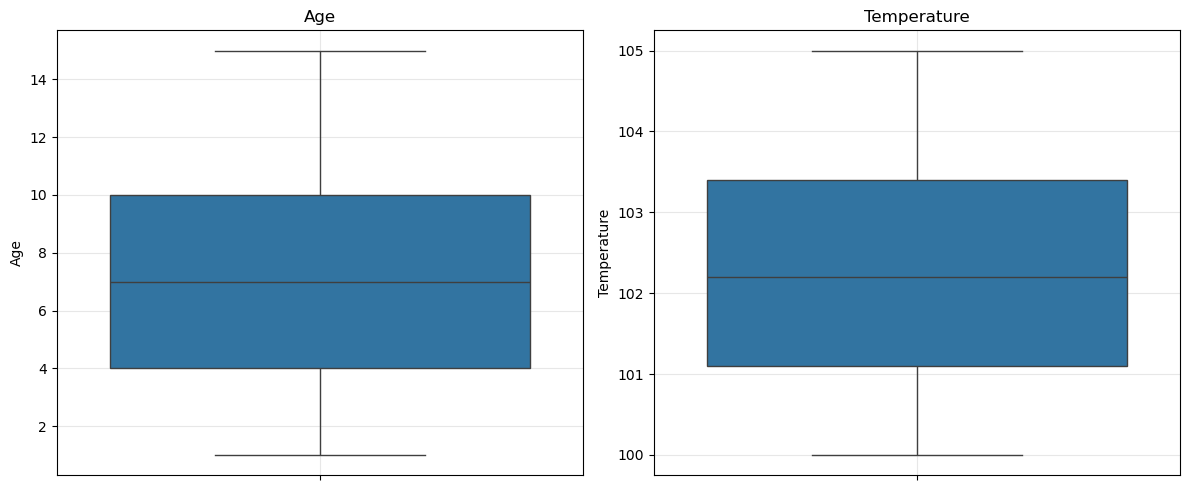

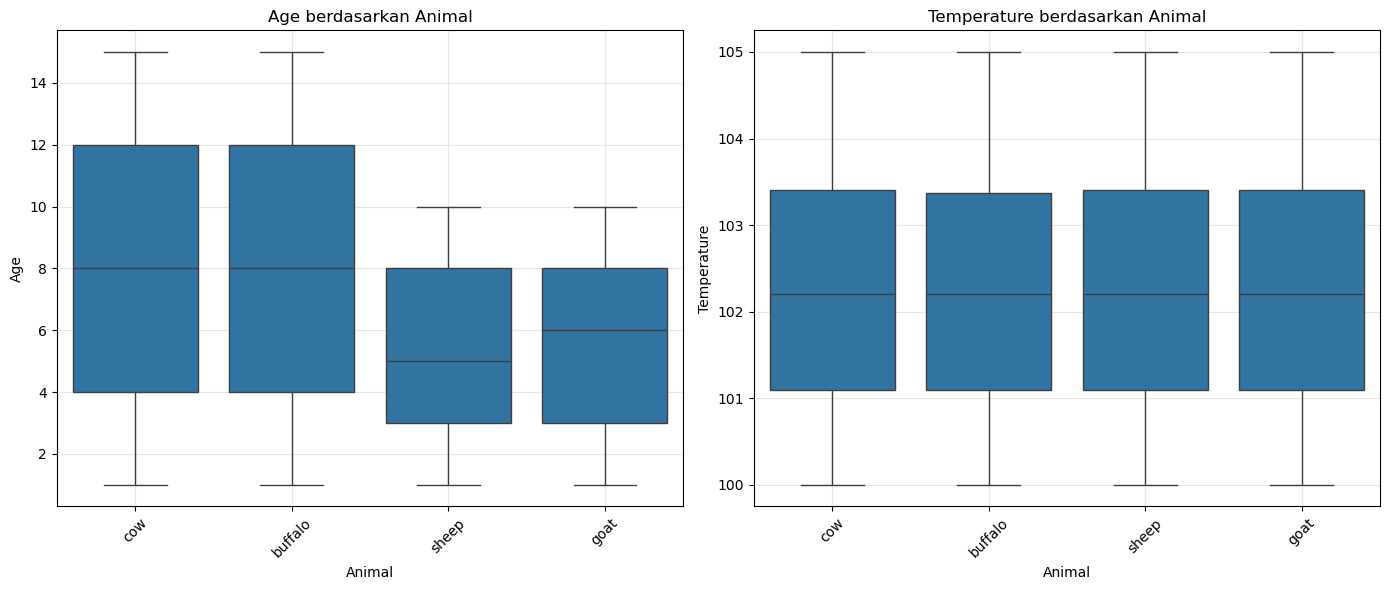

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y='Age', data=df)
plt.title('Age')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.boxplot(y='Temperature', data=df)
plt.title('Temperature')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Animal', y='Age', data=df)
plt.title('Age berdasarkan Animal')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.boxplot(x='Animal', y='Temperature', data=df)
plt.title('Temperature berdasarkan Animal')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

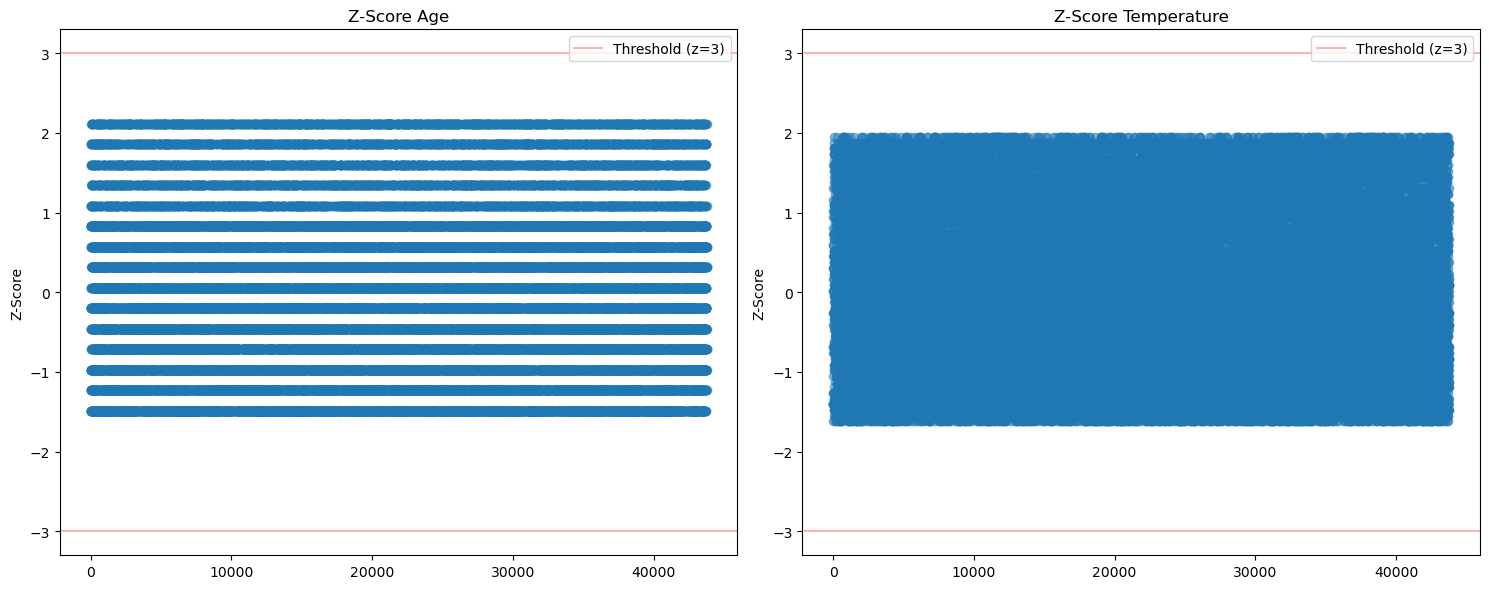

Jumlah outliers dalam Age: 0
Jumlah outliers dalam Temperature: 0


In [11]:
df_z = df.copy()

for col in ['Age', 'Temperature']:
    col_zscore = col + '_zscore'
    df_z[col_zscore] = stats.zscore(df_z[col])
    
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_z.index, df_z['Age_zscore'], alpha=0.5)
plt.axhline(y=3, color='r', linestyle='-', alpha=0.3, label='Threshold (z=3)')
plt.axhline(y=-3, color='r', linestyle='-', alpha=0.3)
plt.title('Z-Score Age')
plt.ylabel('Z-Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(df_z.index, df_z['Temperature_zscore'], alpha=0.5)
plt.axhline(y=3, color='r', linestyle='-', alpha=0.3, label='Threshold (z=3)')
plt.axhline(y=-3, color='r', linestyle='-', alpha=0.3)
plt.title('Z-Score Temperature')
plt.ylabel('Z-Score')
plt.legend()

plt.tight_layout()
plt.show()

age_outliers = len(df_z[abs(df_z['Age_zscore']) > 3])
temp_outliers = len(df_z[abs(df_z['Temperature_zscore']) > 3])
print(f"Jumlah outliers dalam Age: {age_outliers}")
print(f"Jumlah outliers dalam Temperature: {temp_outliers}")

Tidak terdapat outliers pada kedua kolom numerikal

#### 2.2.5 Univariate Analysis

Mengelompokkan fitur menjadi fitur kategorikal dan numerikal

In [12]:
cat_features = df.select_dtypes(include=['object']).columns
num_features = df.select_dtypes(include=[np.number]).columns

a. Fitur Kategorikal

Menamiplkan distribusi Kolom Animal

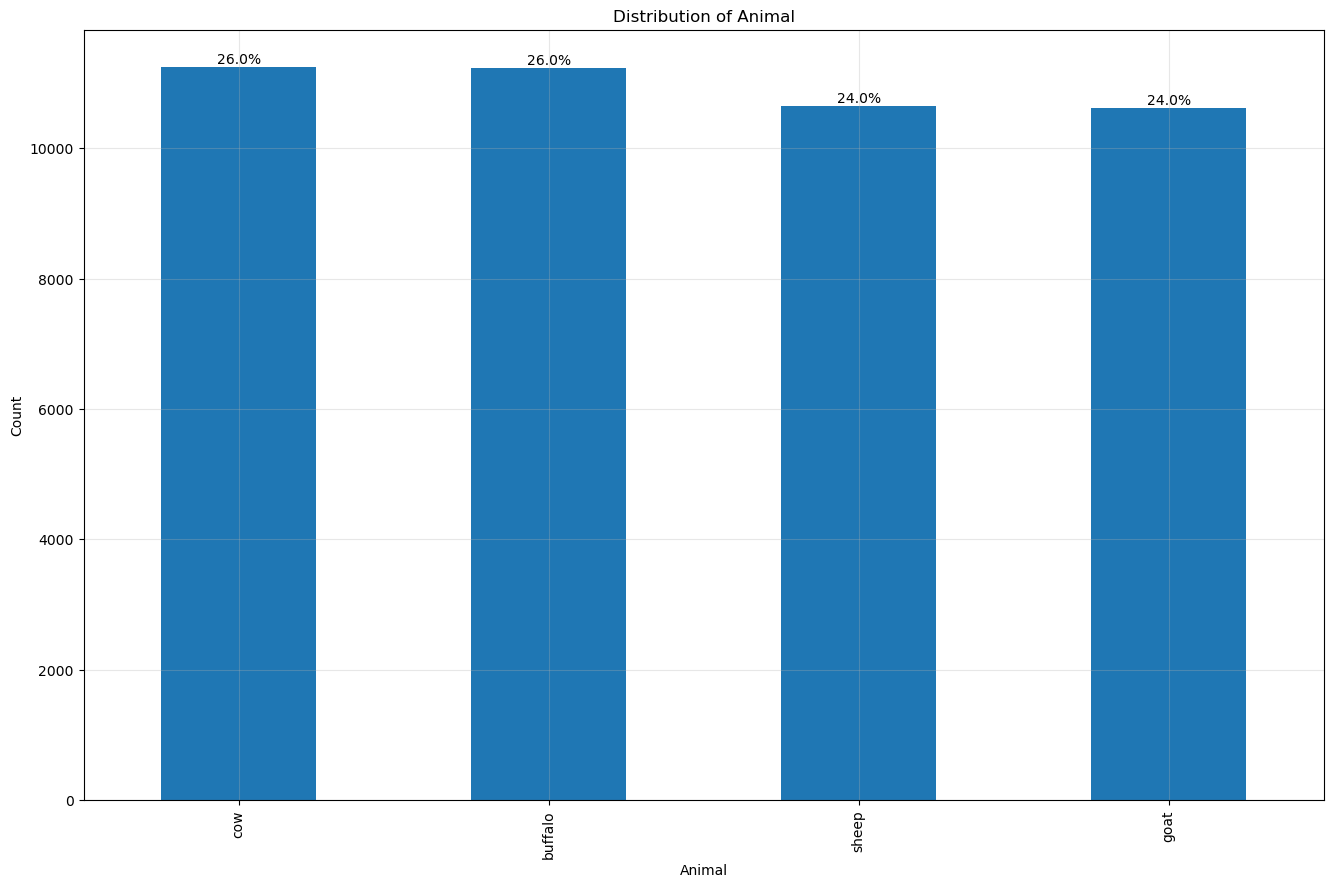

In [13]:
plt.figure(figsize=(16, 10))
animal_counts = df['Animal'].value_counts()
animal_percentages = 100 * df['Animal'].value_counts(normalize=True).round(2)
animal_counts.plot(kind='bar', title='Distribution of Animal')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
for i, p in enumerate(animal_percentages):
    plt.annotate(f"{p}%", (i, animal_counts.iloc[i]), ha='center', va='bottom')

Terdapat 4 kategori pada kolom Animal, dengan distribusi yang cukup seimbang.

Menampilkan distribusi Top 10 pada setiap Kolom Symptoms

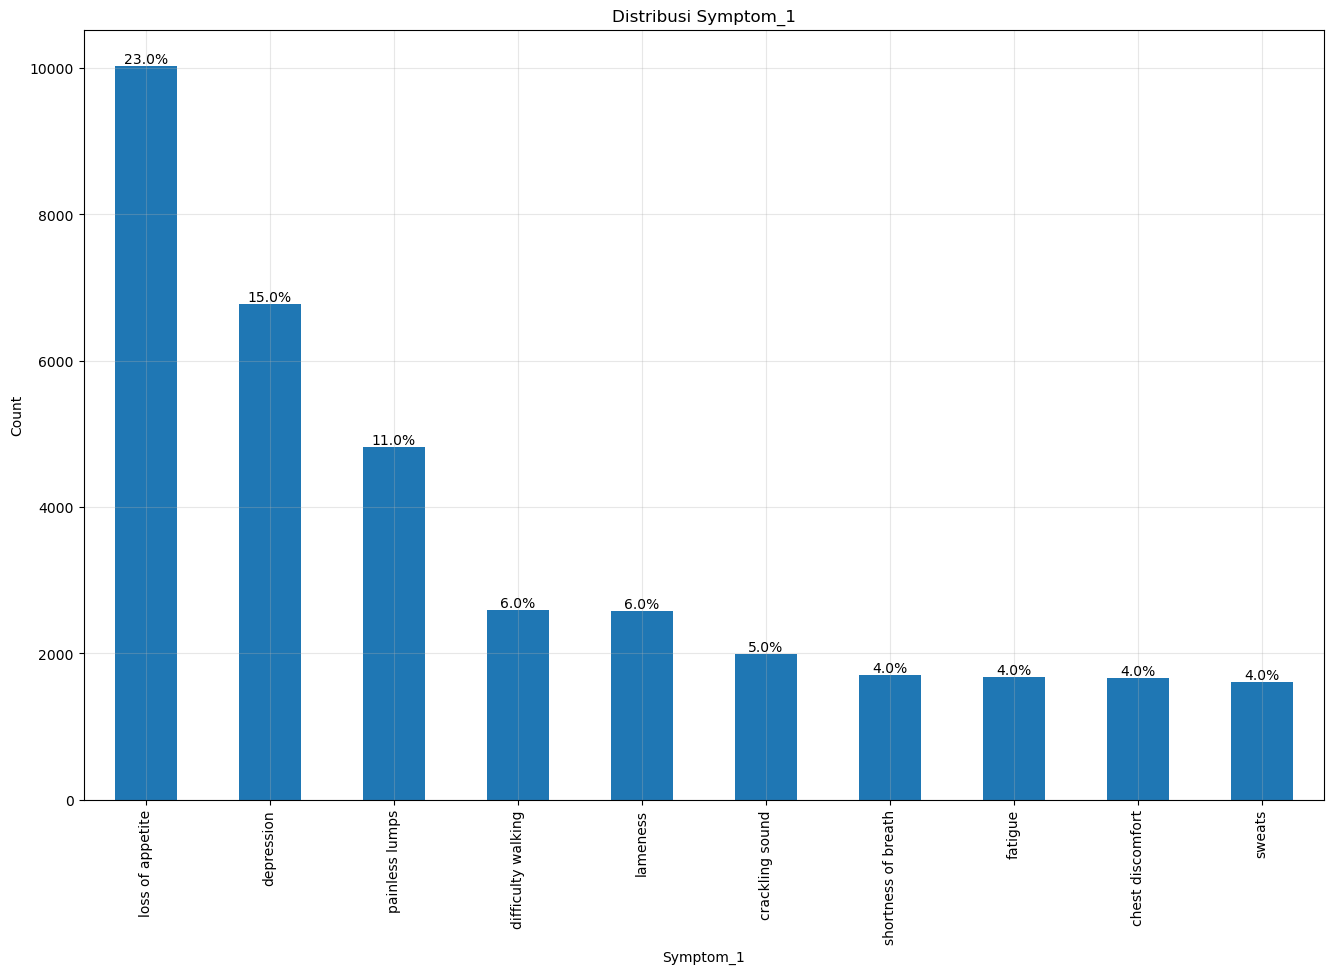

In [14]:
plt.figure(figsize=(16, 10))
symptom1_counts = df['Symptom_1'].value_counts()
symptom1_percentages = 100 * df['Symptom_1'].value_counts(normalize=True).round(2)
if len(symptom1_counts) > 10:
    symptom1_counts = symptom1_counts.head(10)
symptom1_counts.plot(kind='bar', title='Distribusi Symptom_1')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
for i, p in enumerate(symptom1_percentages[:len(symptom1_counts)]):
    plt.annotate(f"{p}%", (i, symptom1_counts.iloc[i]), ha='center', va='bottom')

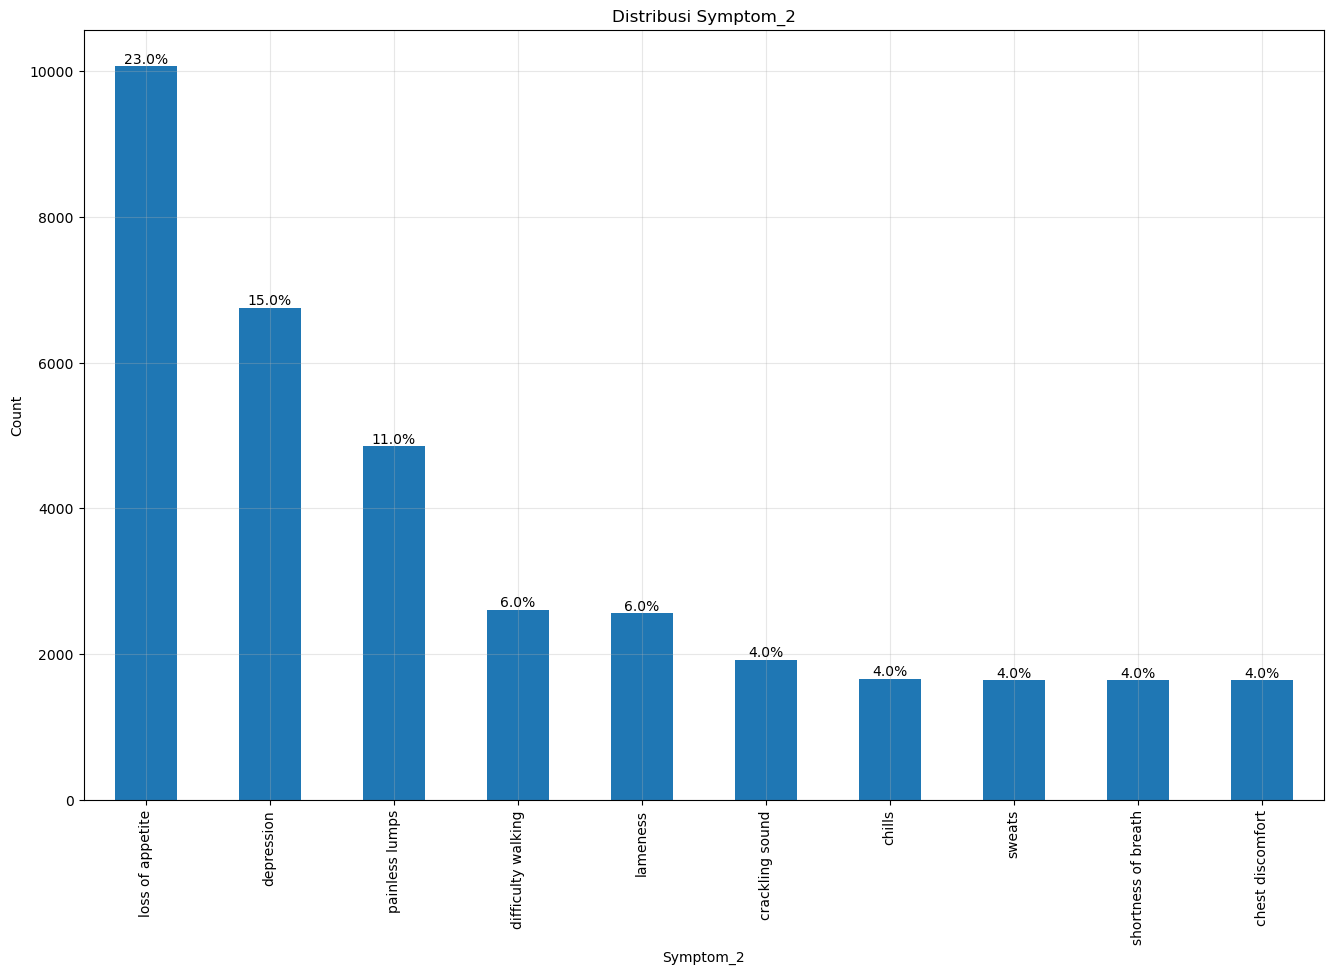

In [15]:
plt.figure(figsize=(16, 10))
symptom2_counts = df['Symptom_2'].value_counts()
symptom2_percentages = 100 * df['Symptom_2'].value_counts(normalize=True).round(2)
if len(symptom2_counts) > 10:
    symptom2_counts = symptom2_counts.head(10)
symptom2_counts.plot(kind='bar', title='Distribusi Symptom_2')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
for i, p in enumerate(symptom2_percentages[:len(symptom2_counts)]):
    plt.annotate(f"{p}%", (i, symptom2_counts.iloc[i]), ha='center', va='bottom')

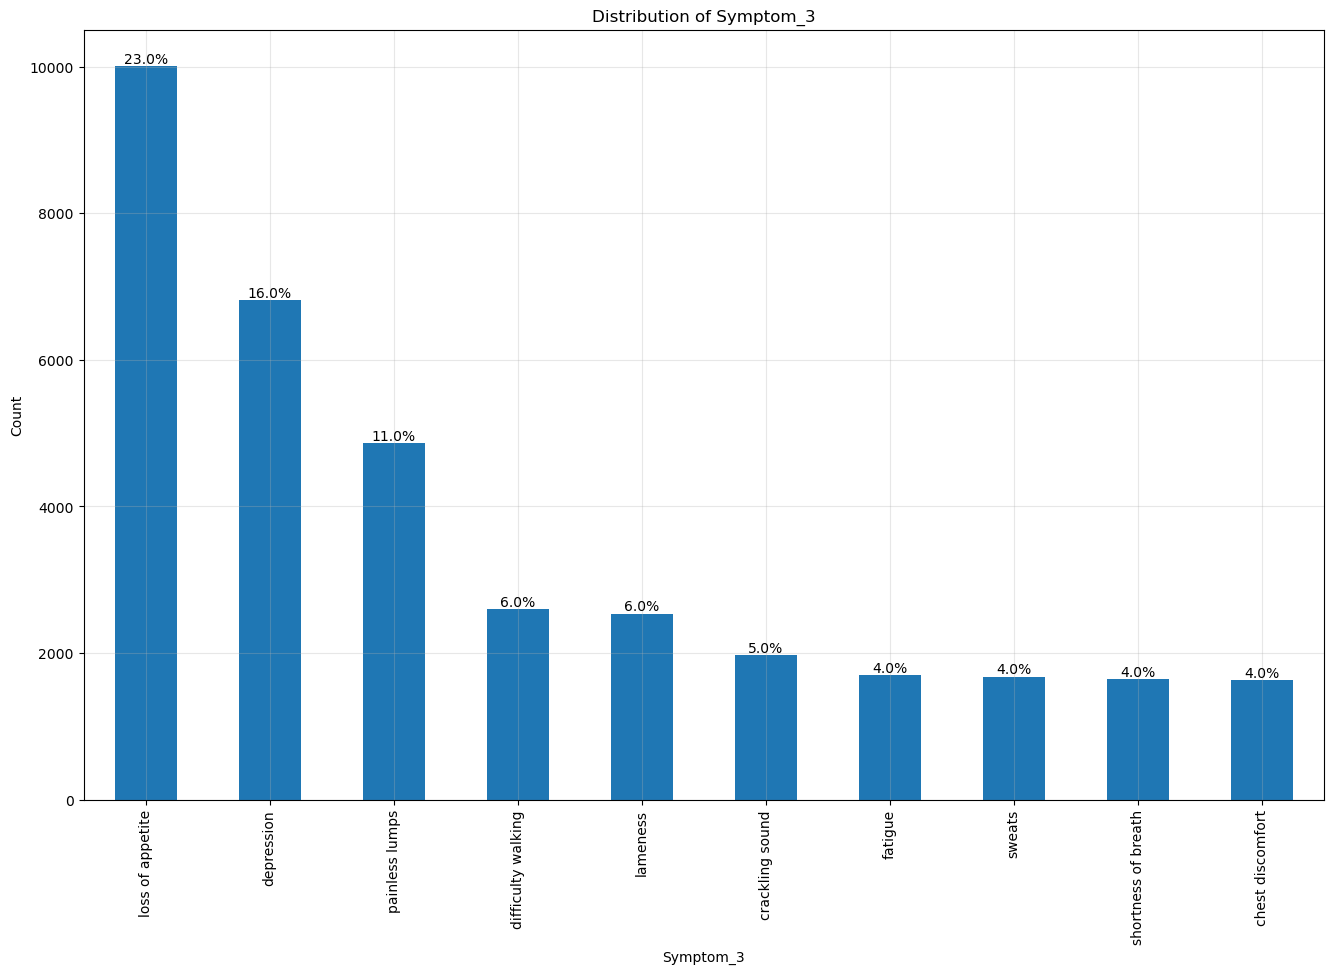

In [16]:
plt.figure(figsize=(16, 10))
symptom3_counts = df['Symptom_3'].value_counts()
symptom3_percentages = 100 * df['Symptom_3'].value_counts(normalize=True).round(2)
if len(symptom3_counts) > 10:
    symptom3_counts = symptom3_counts.head(10)
symptom3_counts.plot(kind='bar', title='Distribution of Symptom_3')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
for i, p in enumerate(symptom3_percentages[:len(symptom3_counts)]):
    plt.annotate(f"{p}%", (i, symptom3_counts.iloc[i]), ha='center', va='bottom')

Ketiga kolom menunjukkan pola distribusi yang hampir identik pada semua kategori gejala (Symptom_1, Symptom_2, dan Symptom_3), dengan "loss of appetite" (23%) konsisten menjadi gejala yang paling umum, diikuti oleh "depression" (15-16%) dan "painful lumps" (11%), menandakan gejala pada hewan ternak yang mungkin mengindikasikan sindrom penyakit yang konsisten

Menampilkan distribusi Kolom Disease

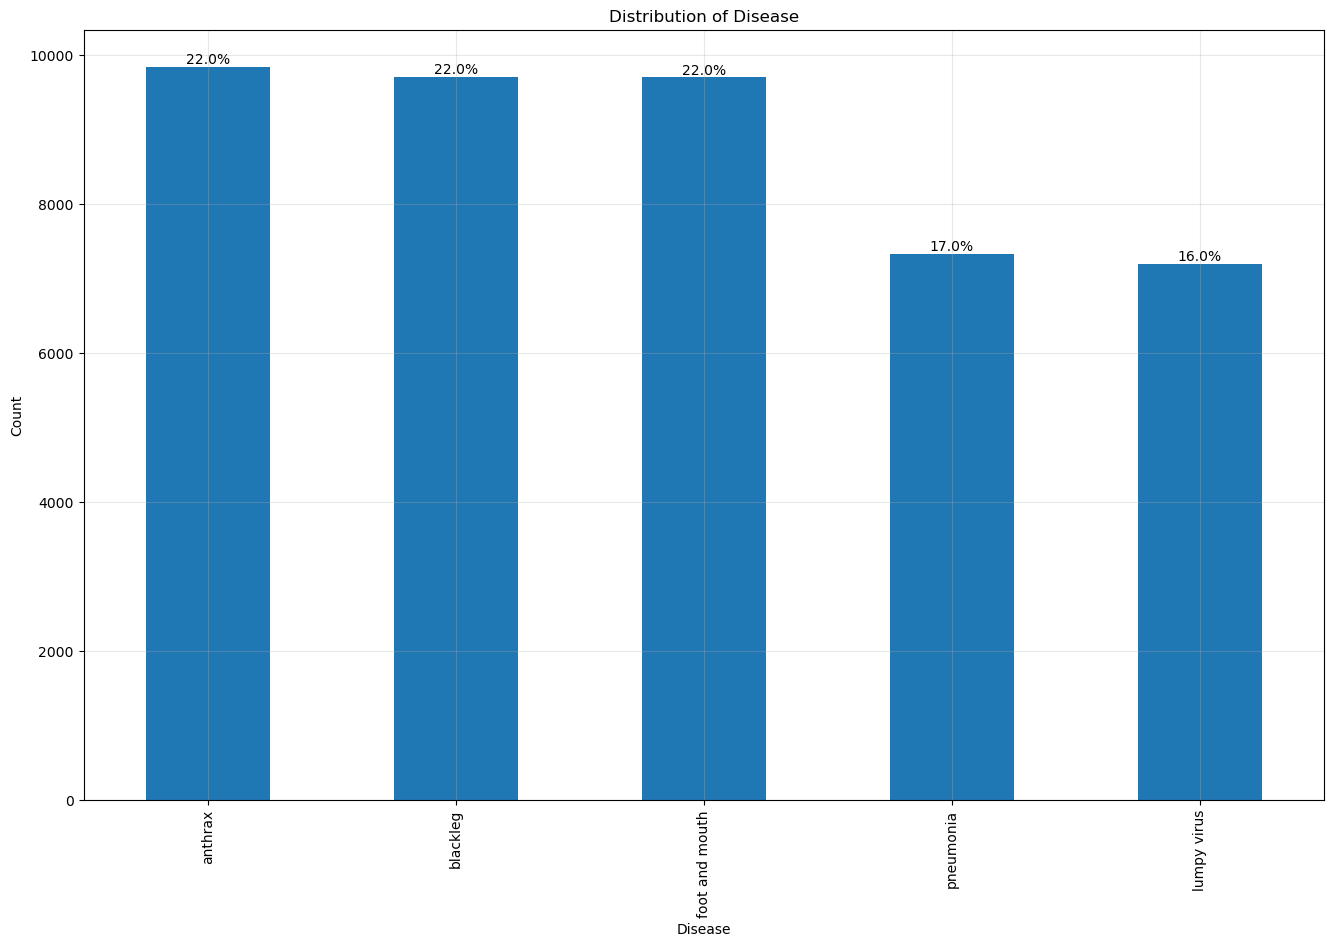

In [17]:
plt.figure(figsize=(16, 10))
disease_counts = df['Disease'].value_counts()
disease_percentages = 100 * df['Disease'].value_counts(normalize=True).round(2)
if len(disease_counts) > 10:
    disease_counts = disease_counts.head(10)
disease_counts.plot(kind='bar', title='Distribution of Disease')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
for i, p in enumerate(disease_percentages[:len(disease_counts)]):
    plt.annotate(f"{p}%", (i, disease_counts.iloc[i]), ha='center', va='bottom')


Distribusi penyakit pada dataset menunjukkan pola yang relatif seimbang dengan dominasi tiga penyakit utama yaitu anthrax, blackleg, dan foot and mouth disease yang masing-masing menyumbang 22% dari seluruh kasus. Pneumonia (17%) dan lumpy virus (16%), menandakan bahwa dataset memiliki representasi yang baik dari lima penyakit utama pada ternak, dengan penekanan sedikit lebih besar pada penyakit-penyakit yang berpotensi fatal dan sangat menular

In [18]:
for feature in ['Animal', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Disease']:
    counts = df[feature].value_counts()
    percentages = 100 * df[feature].value_counts(normalize=True).round(2)

    summary = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages})
    
    print(f"\n--- {feature} ---")
    if len(summary) > 15:
        print(summary.head(15))
        print(f"... and {len(summary)-15} more categories")
    else:
        print(summary)


--- Animal ---
         Count  Percentage (%)
Animal                        
cow      11254            26.0
buffalo  11238            26.0
sheep    10658            24.0
goat     10628            24.0

--- Symptom_1 ---
                         Count  Percentage (%)
Symptom_1                                     
loss of appetite         10026            23.0
depression                6770            15.0
painless lumps            4815            11.0
difficulty walking        2594             6.0
lameness                  2578             6.0
crackling sound           1991             5.0
shortness of breath       1698             4.0
fatigue                   1678             4.0
chest discomfort          1659             4.0
sweats                    1604             4.0
chills                    1597             4.0
swelling in muscle         972             2.0
swelling in limb           933             2.0
swelling in extremities    538             1.0
swelling in neck           

b. Fitur Numerikal

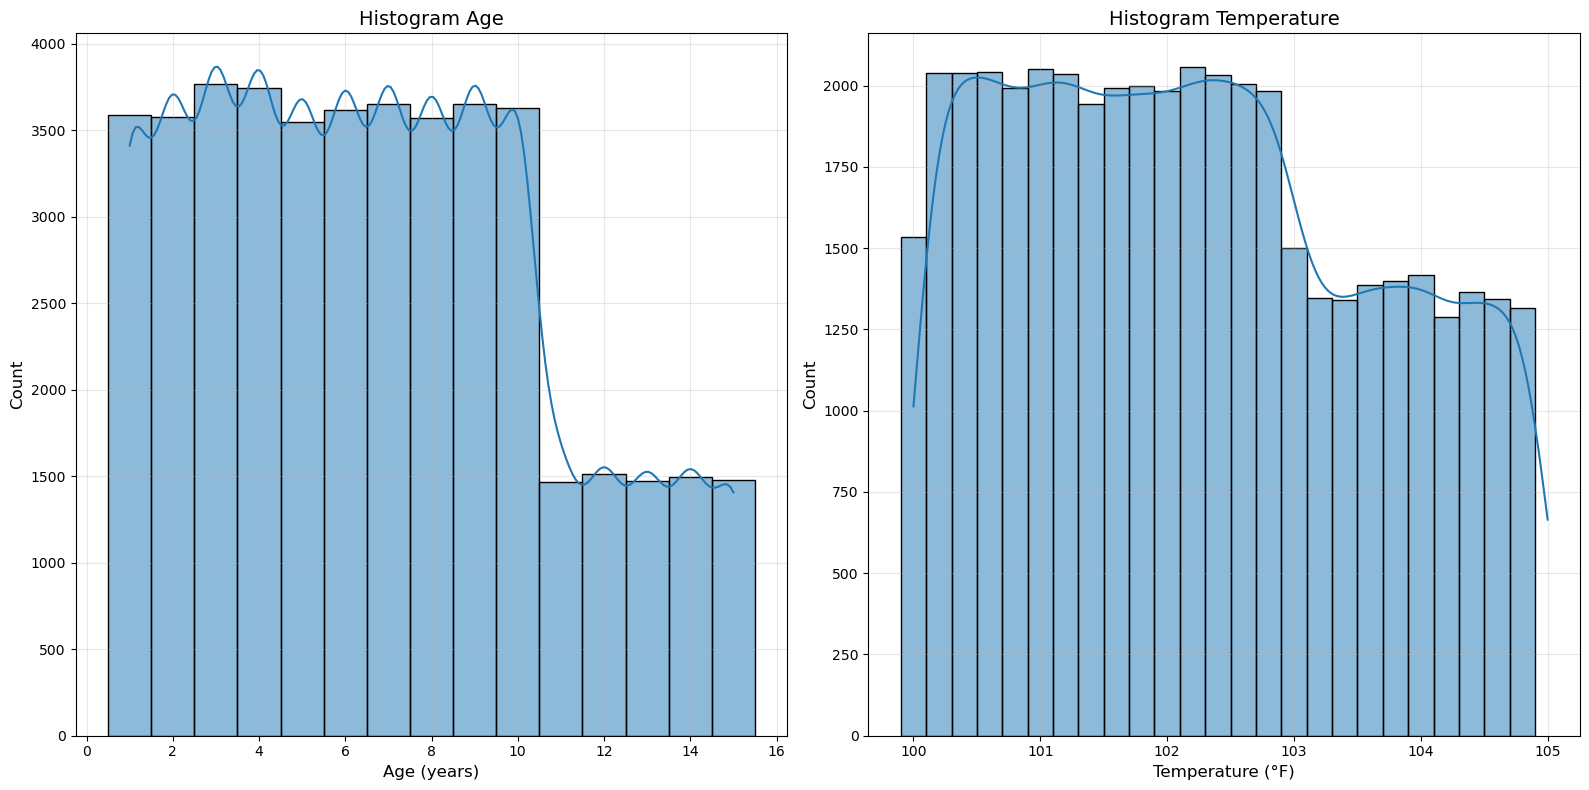

In [19]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
age_bins = np.arange(df['Age'].min() - 0.5, df['Age'].max() + 1.5, 1)
sns.histplot(df['Age'], bins=age_bins, kde=True)
plt.title('Histogram Age', fontsize=14)
plt.xlabel('Age (years)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
temp_bins = np.arange(df['Temperature'].min() - 0.1, df['Temperature'].max() + 0.1, 0.2)
sns.histplot(df['Temperature'], bins=temp_bins, kde=True)
plt.title('Histogram Temperature', fontsize=14)
plt.xlabel('Temperature (°F)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Histogram usia menunjukkan distribusi bimodal dengan mayoritas hewan berusia 1-10 tahun dan kelompok kedua yang lebih kecil pada usia 11-15 tahun, sementara histogram suhu tubuh memperlihatkan konsentrasi utama pada rentang normal (100-102.5°F) dan kelompok sekunder pada rentang demam (103-104.5°F).

#### 2.2.6 Multivariate Analysis

a. Fitur Kategorikal

Melihat distribusi penyakit bedasarkan jenis hewan ternak

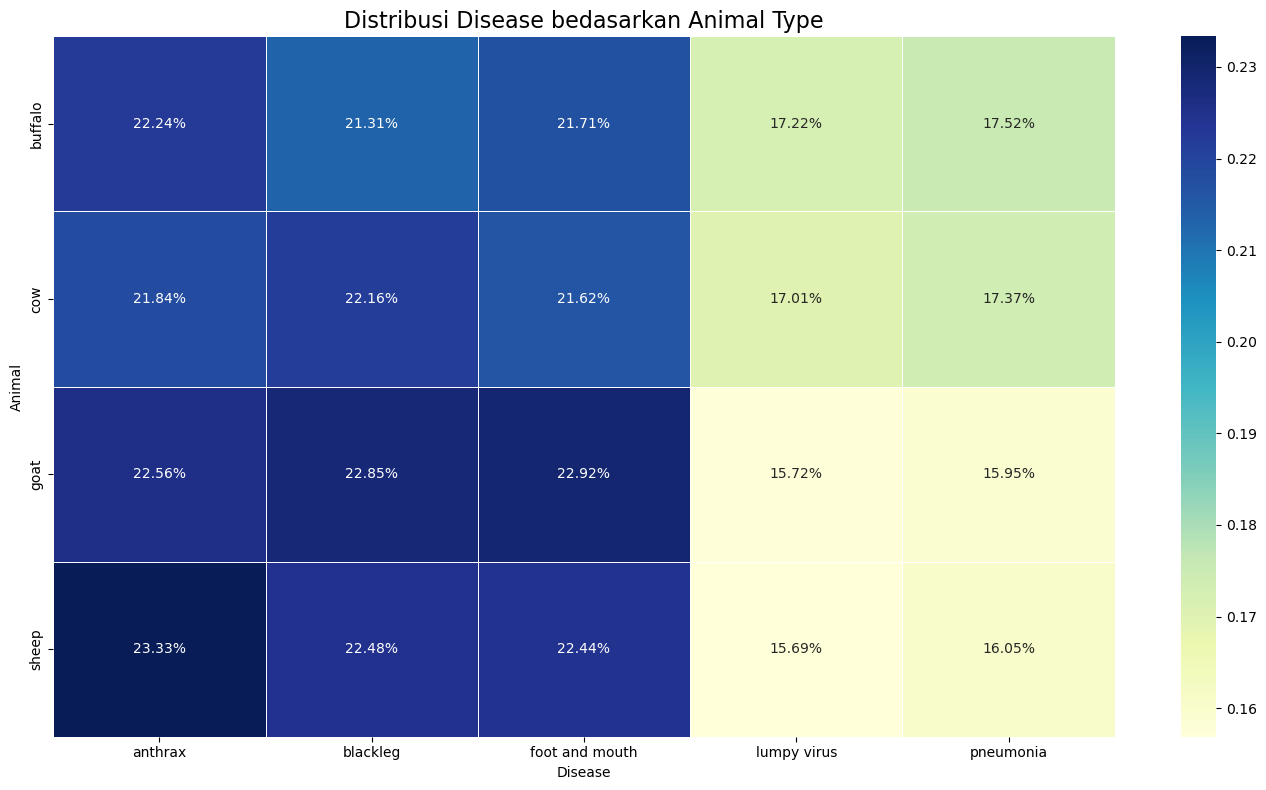

In [51]:
plt.figure(figsize=(14, 8))
animal_disease = pd.crosstab(df['Animal'], df['Disease'], normalize='index')
sns.heatmap(animal_disease, annot=True, cmap='YlGnBu', fmt='.2%', linewidths=.5)
plt.title('Distribusi Disease bedasarkan Animal Type', fontsize=16)
plt.ylabel('Animal')
plt.xlabel('Disease')
plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

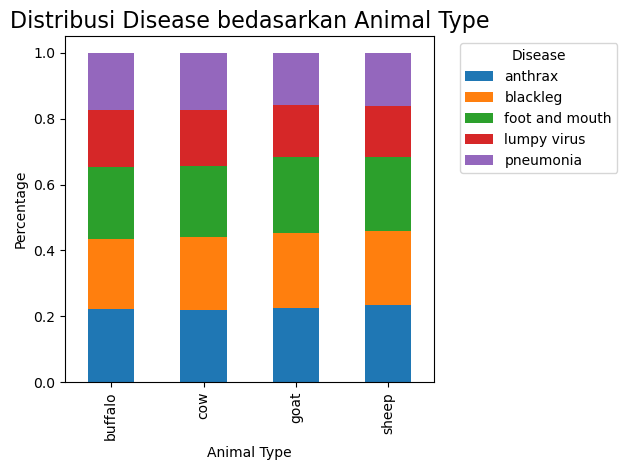

In [21]:
plt.figure(figsize=(14, 8))
pd.crosstab(df['Animal'], df['Disease'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Distribusi Disease bedasarkan Animal Type', fontsize=16)
plt.xlabel('Animal Type')
plt.ylabel('Percentage')
plt.legend(title='Disease', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()

- Tiga penyakit utama (anthrax, blackleg, foot and mouth) konsisten mendominasi pada semua jenis hewan dengan prevalensi sekitar 21-23%.
- Domba (sheep) memiliki tingkat infeksi anthrax tertinggi (23.33%) dibandingkan hewan lainnya.
- Kambing (goat) menunjukkan kasus foot and mouth disease tertinggi (22.92%).
- Kerbau (buffalo) dan sapi (cow) memiliki pola distribusi penyakit yang mirip.
- Lumpy virus dan pneumonia konsisten menjadi penyakit dengan prevalensi lebih rendah (15-17%) pada semua jenis hewan.
- Sapi menunjukkan distribusi penyakit paling seimbang dengan variasi persentase antar penyakit lebih kecil.
- Kambing dan domba memiliki insiden lumpy virus dan pneumonia lebih rendah dibandingkan kerbau dan sapi.

Melihat distribusi gejala bedasarkan penyakit

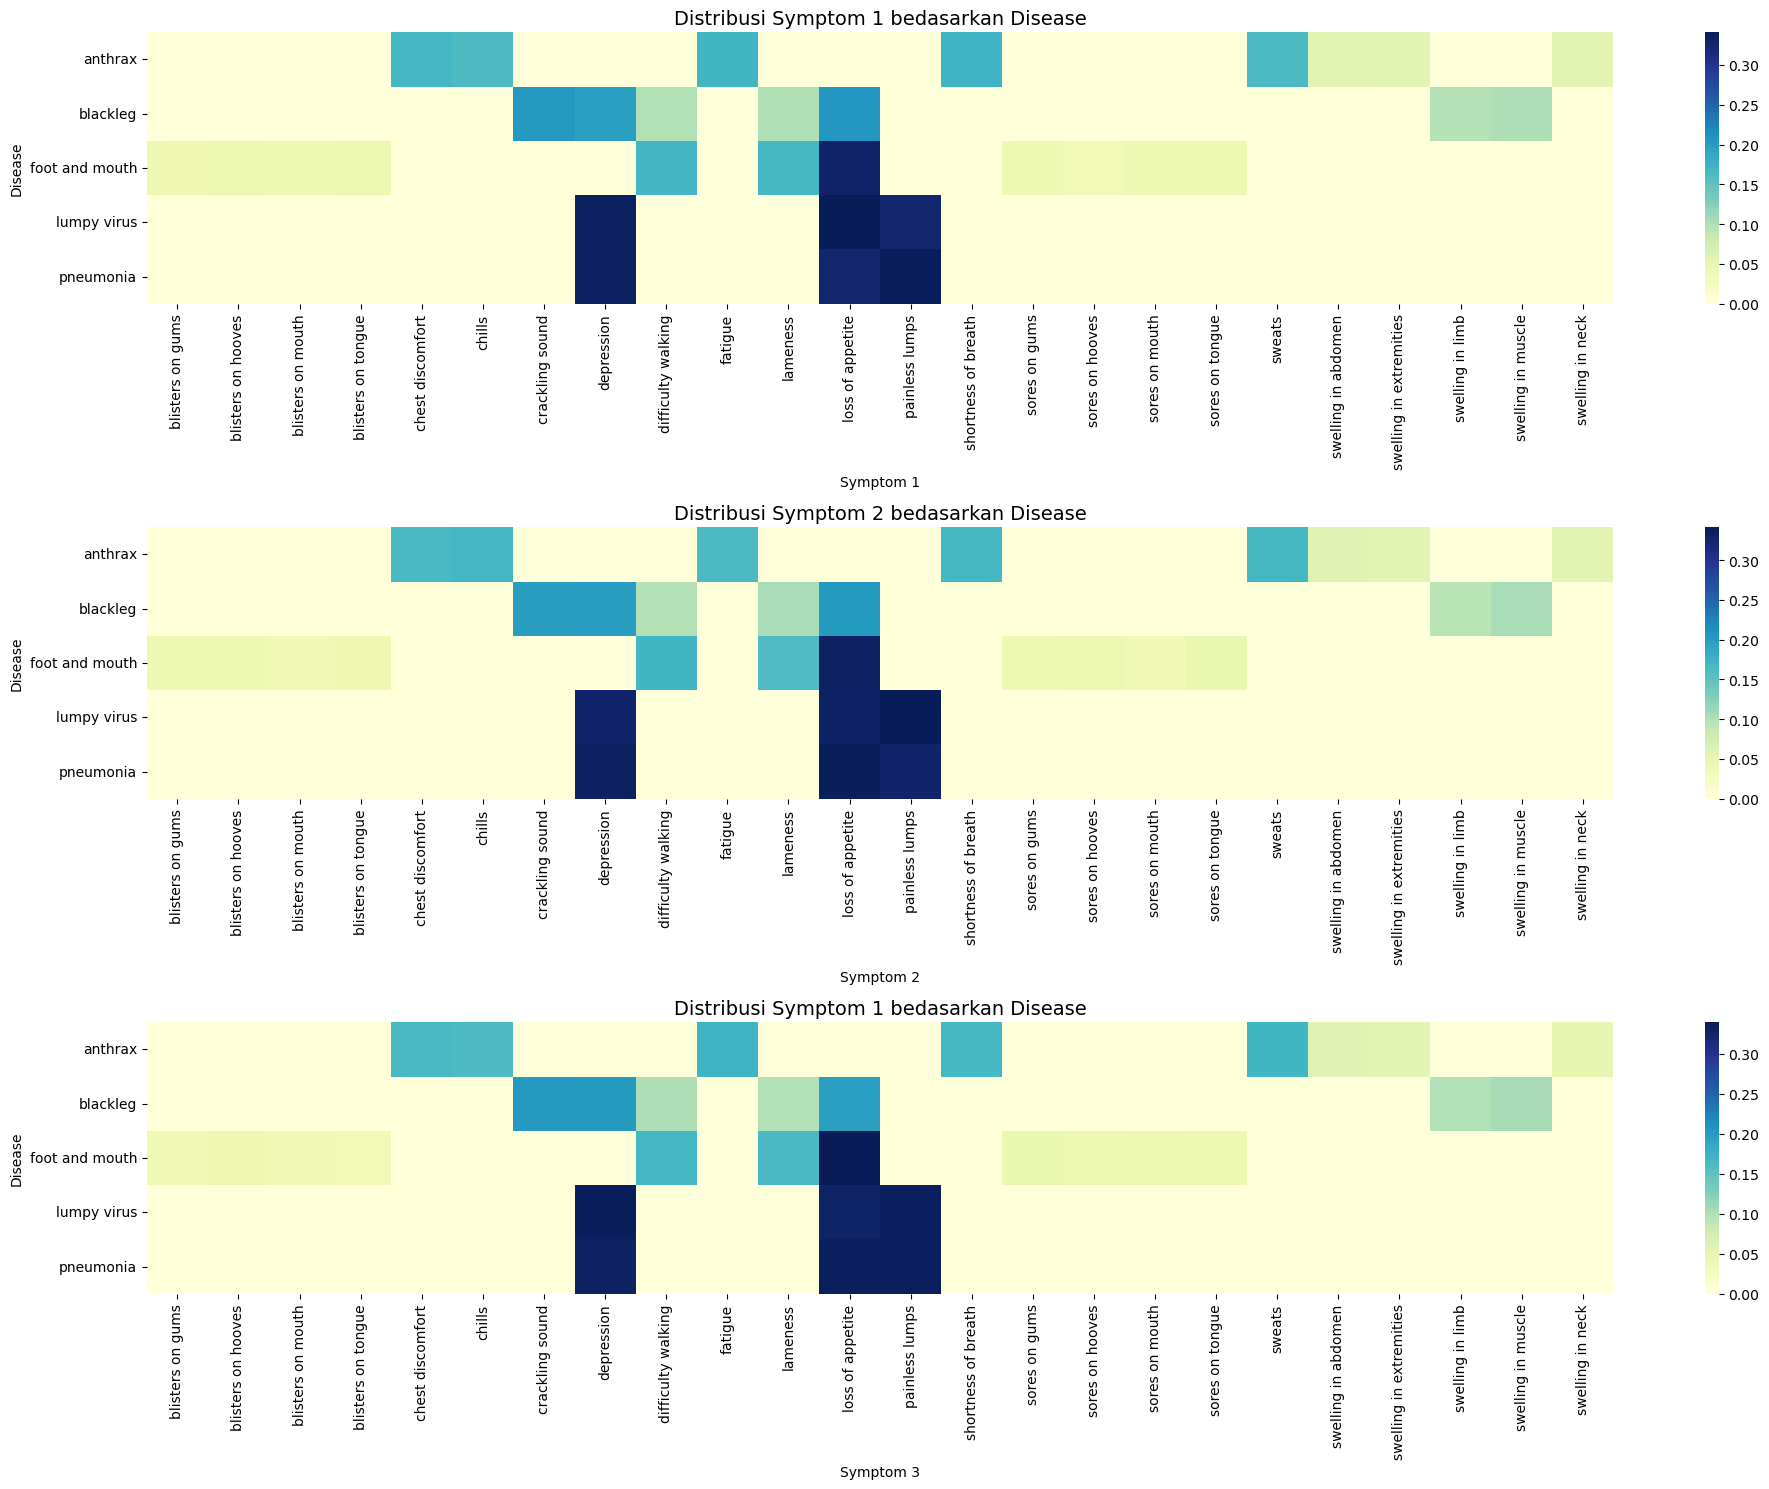

In [22]:
plt.figure(figsize=(20, 15))

plt.subplot(3, 1, 1)
symptom1_disease = pd.crosstab(df['Disease'], df['Symptom_1'], normalize='index')
sns.heatmap(symptom1_disease, cmap='YlGnBu', annot=False)
plt.title('Distribusi Symptom 1 bedasarkan Disease', fontsize=14)
plt.ylabel('Disease')
plt.xlabel('Symptom 1')

plt.subplot(3, 1, 2)
symptom2_disease = pd.crosstab(df['Disease'], df['Symptom_2'], normalize='index')
sns.heatmap(symptom2_disease, cmap='YlGnBu', annot=False)
plt.title('Distribusi Symptom 2 bedasarkan Disease', fontsize=14)
plt.ylabel('Disease')
plt.xlabel('Symptom 2')

plt.subplot(3, 1, 3)
symptom3_disease = pd.crosstab(df['Disease'], df['Symptom_3'], normalize='index')
sns.heatmap(symptom3_disease, cmap='YlGnBu', annot=False)
plt.title('Distribusi Symptom 1 bedasarkan Disease', fontsize=14)
plt.ylabel('Disease')
plt.xlabel('Symptom 3')

plt.tight_layout()
plt.show()

In [23]:
def display_top_symptoms(disease_name, top_n=3):
    disease_data = df[df['Disease'] == disease_name]
    
    top_symptom1 = disease_data['Symptom_1'].value_counts().nlargest(top_n)
    top_symptom2 = disease_data['Symptom_2'].value_counts().nlargest(top_n)
    top_symptom3 = disease_data['Symptom_3'].value_counts().nlargest(top_n)
    
    print(f"Top symptoms untuk {disease_name}:")
    print(f"Top Symptom 1: {', '.join([f'{s} ({top_symptom1[s]/len(disease_data):.1%})' for s in top_symptom1.index])}")
    print(f"Top Symptom 2: {', '.join([f'{s} ({top_symptom2[s]/len(disease_data):.1%})' for s in top_symptom2.index])}")
    print(f"Top Symptom 3: {', '.join([f'{s} ({top_symptom3[s]/len(disease_data):.1%})' for s in top_symptom3.index])}")
    print()

for disease in df['Disease'].unique():
    display_top_symptoms(disease)

Top symptoms untuk pneumonia:
Top Symptom 1: painless lumps (33.9%), depression (33.5%), loss of appetite (32.6%)
Top Symptom 2: loss of appetite (33.9%), depression (33.4%), painless lumps (32.7%)
Top Symptom 3: loss of appetite (33.5%), painless lumps (33.5%), depression (33.0%)

Top symptoms untuk lumpy virus:
Top Symptom 1: loss of appetite (34.1%), depression (33.5%), painless lumps (32.4%)
Top Symptom 2: painless lumps (34.1%), loss of appetite (33.1%), depression (32.8%)
Top Symptom 3: depression (33.8%), painless lumps (33.5%), loss of appetite (32.8%)

Top symptoms untuk blackleg:
Top Symptom 1: loss of appetite (20.6%), crackling sound (20.5%), depression (19.6%)
Top Symptom 2: loss of appetite (20.4%), depression (20.0%), crackling sound (19.8%)
Top Symptom 3: crackling sound (20.3%), depression (20.2%), loss of appetite (19.5%)

Top symptoms untuk foot and mouth:
Top Symptom 1: loss of appetite (32.8%), difficulty walking (16.9%), lameness (16.7%)
Top Symptom 2: loss of app

- Pneumonia dan lumpy virus menunjukkan profil gejala yang hampir identik (painless lumps, depression, loss of appetite), menjadikannya sulit dibedakan hanya dari gejala klinis.

- Blackleg memiliki ciri khas berupa "crackling sound" yang tidak muncul di penyakit lainnya, menjadikannya indikator diagnostik penting.

- Foot and mouth disease ditandai dengan gangguan mobilitas (difficulty walking, lameness) yang mencerminkan efek penyakit pada kaki hewan.

- Anthrax memiliki profil gejala yang sepenuhnya berbeda, dengan fokus pada gejala pernapasan (shortness of breath, chest discomfort) dan sistemik (fatigue, sweats, chills).

- "Loss of appetite" muncul sebagai gejala utama pada 4 dari 5 penyakit, membuatnya kurang spesifik untuk diagnosis.

- Distribusi persentase gejala lebih merata pada blackleg dan anthrax (~16-20%), menunjukkan tidak ada satu gejala yang sangat dominan.

b. Fitur Numerikal

Melihat distribusi umur dan temperatur bedasarkan penyakit

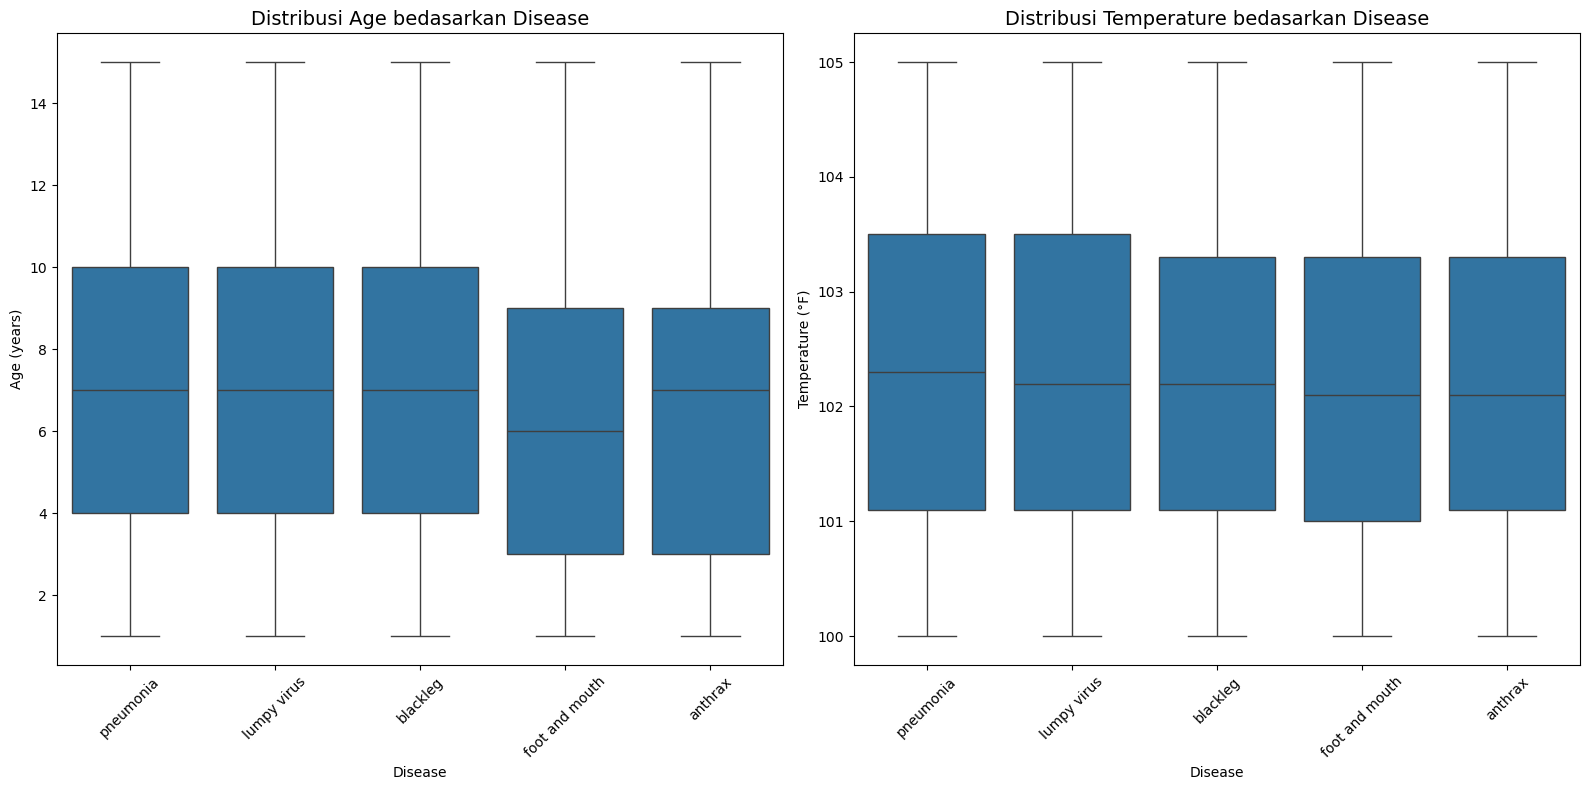

In [24]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.boxplot(x='Disease', y='Age', data=df)
plt.title('Distribusi Age bedasarkan Disease', fontsize=14)
plt.xlabel('Disease')
plt.ylabel('Age (years)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='Disease', y='Temperature', data=df)
plt.title('Distribusi Temperature bedasarkan Disease', fontsize=14)
plt.xlabel('Disease')
plt.ylabel('Temperature (°F)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

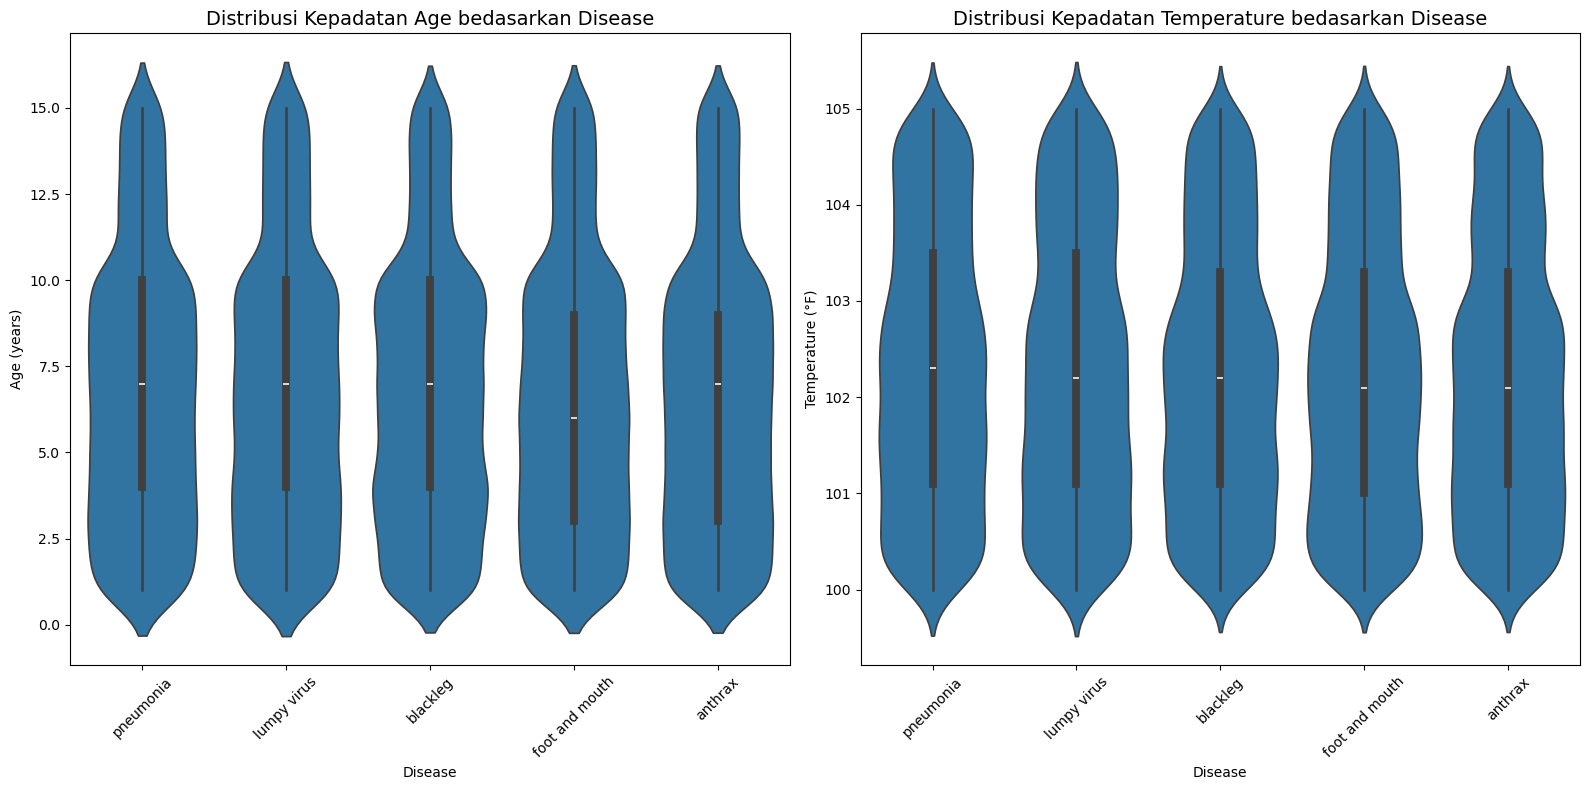

In [25]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x='Disease', y='Age', data=df)
plt.title('Distribusi Kepadatan Age bedasarkan Disease', fontsize=14)
plt.xlabel('Disease')
plt.ylabel('Age (years)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.violinplot(x='Disease', y='Temperature', data=df)
plt.title('Distribusi Kepadatan Temperature bedasarkan Disease', fontsize=14)
plt.xlabel('Disease')
plt.ylabel('Temperature (°F)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

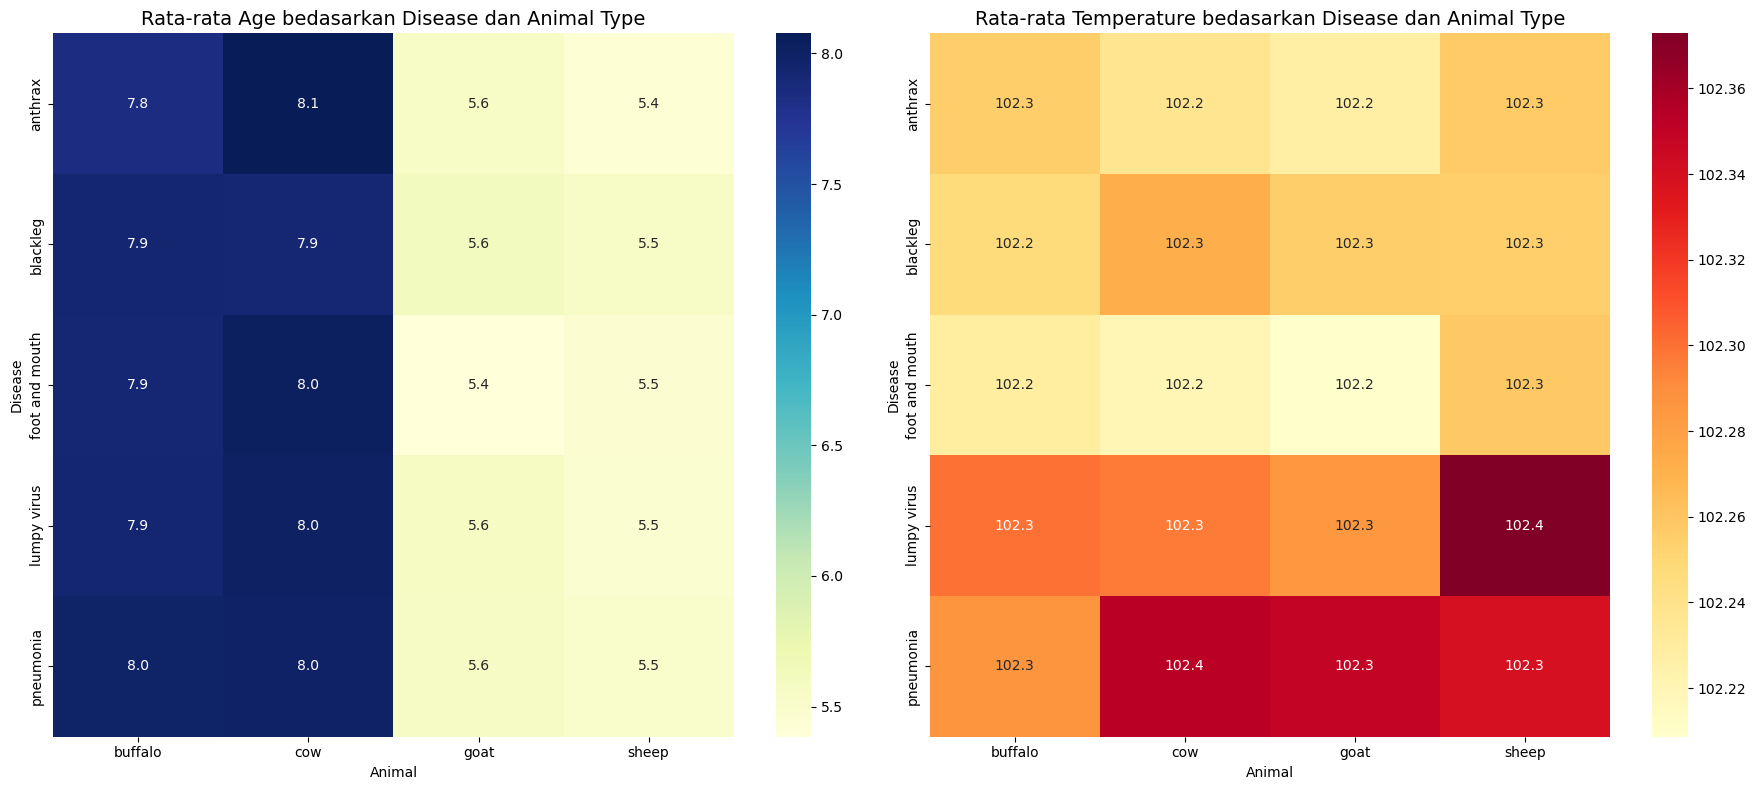

In [26]:

disease_animal_stats = df.groupby(['Disease', 'Animal']).agg({
    'Age': 'mean',
    'Temperature': 'mean'
}).reset_index()

age_pivot = disease_animal_stats.pivot(index='Disease', columns='Animal', values='Age')
temp_pivot = disease_animal_stats.pivot(index='Disease', columns='Animal', values='Temperature')

plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
sns.heatmap(age_pivot, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Rata-rata Age bedasarkan Disease dan Animal Type', fontsize=14)

plt.subplot(1, 2, 2)
sns.heatmap(temp_pivot, annot=True, cmap='YlOrRd', fmt='.1f')
plt.title('Rata-rata Temperature bedasarkan Disease dan Animal Type', fontsize=14)

plt.tight_layout()
plt.show()

- Foot and mouth disease dan anthrax menyerang hewan dengan median usia lebih muda (sekitar 6 tahun) dibandingkan penyakit lainnya (sekitar 7 tahun).

- Pneumonia dan lumpy virus menunjukkan temperatur tubuh median sedikit lebih tinggi dibandingkan penyakit lain.

- Distribusi usia menunjukkan pola bimodal pada semua penyakit, dengan konsentrasi pada usia 3-4 dan 9-10 tahun.

- Buffalo dan sapi secara konsisten lebih tua (7.8-8.1 tahun) dibandingkan kambing dan domba (5.4-5.6 tahun) terlepas dari jenis penyakitnya.

- Variasi temperatur relatif kecil (102.2-102.4°F) di semua kombinasi penyakit dan jenis hewan.

- Domba dengan lumpy virus dan sapi dengan pneumonia menunjukkan temperatur rata-rata tertinggi (102.4°F).

- Variasi temperatur lebih dipengaruhi oleh jenis penyakit daripada jenis hewan.

#### 2.2.7 Correlation Matrix

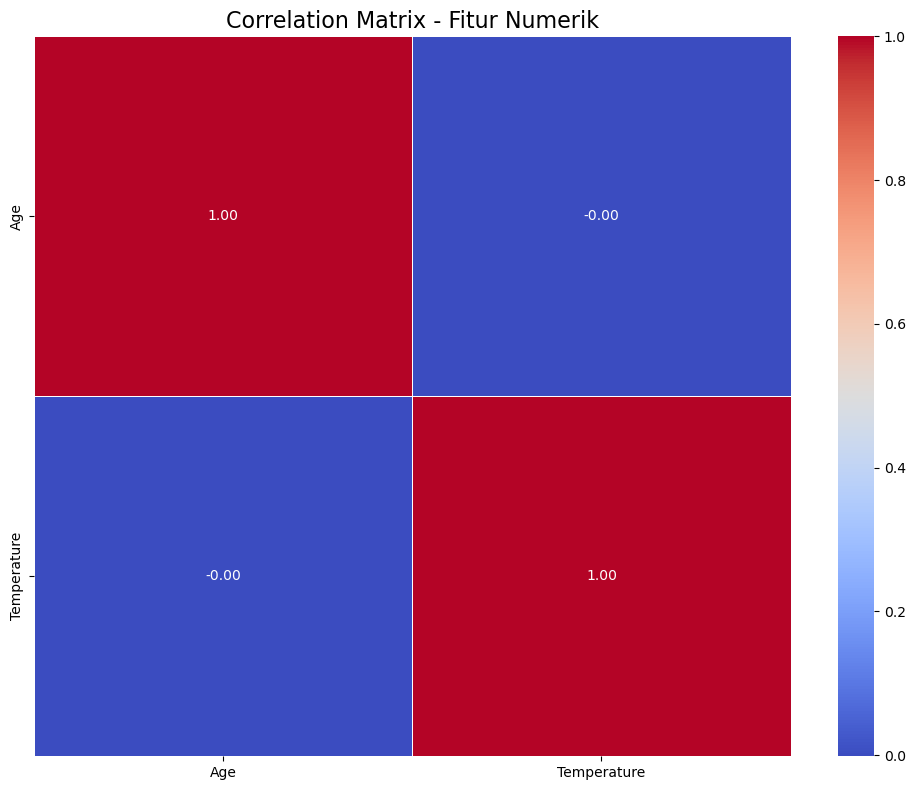

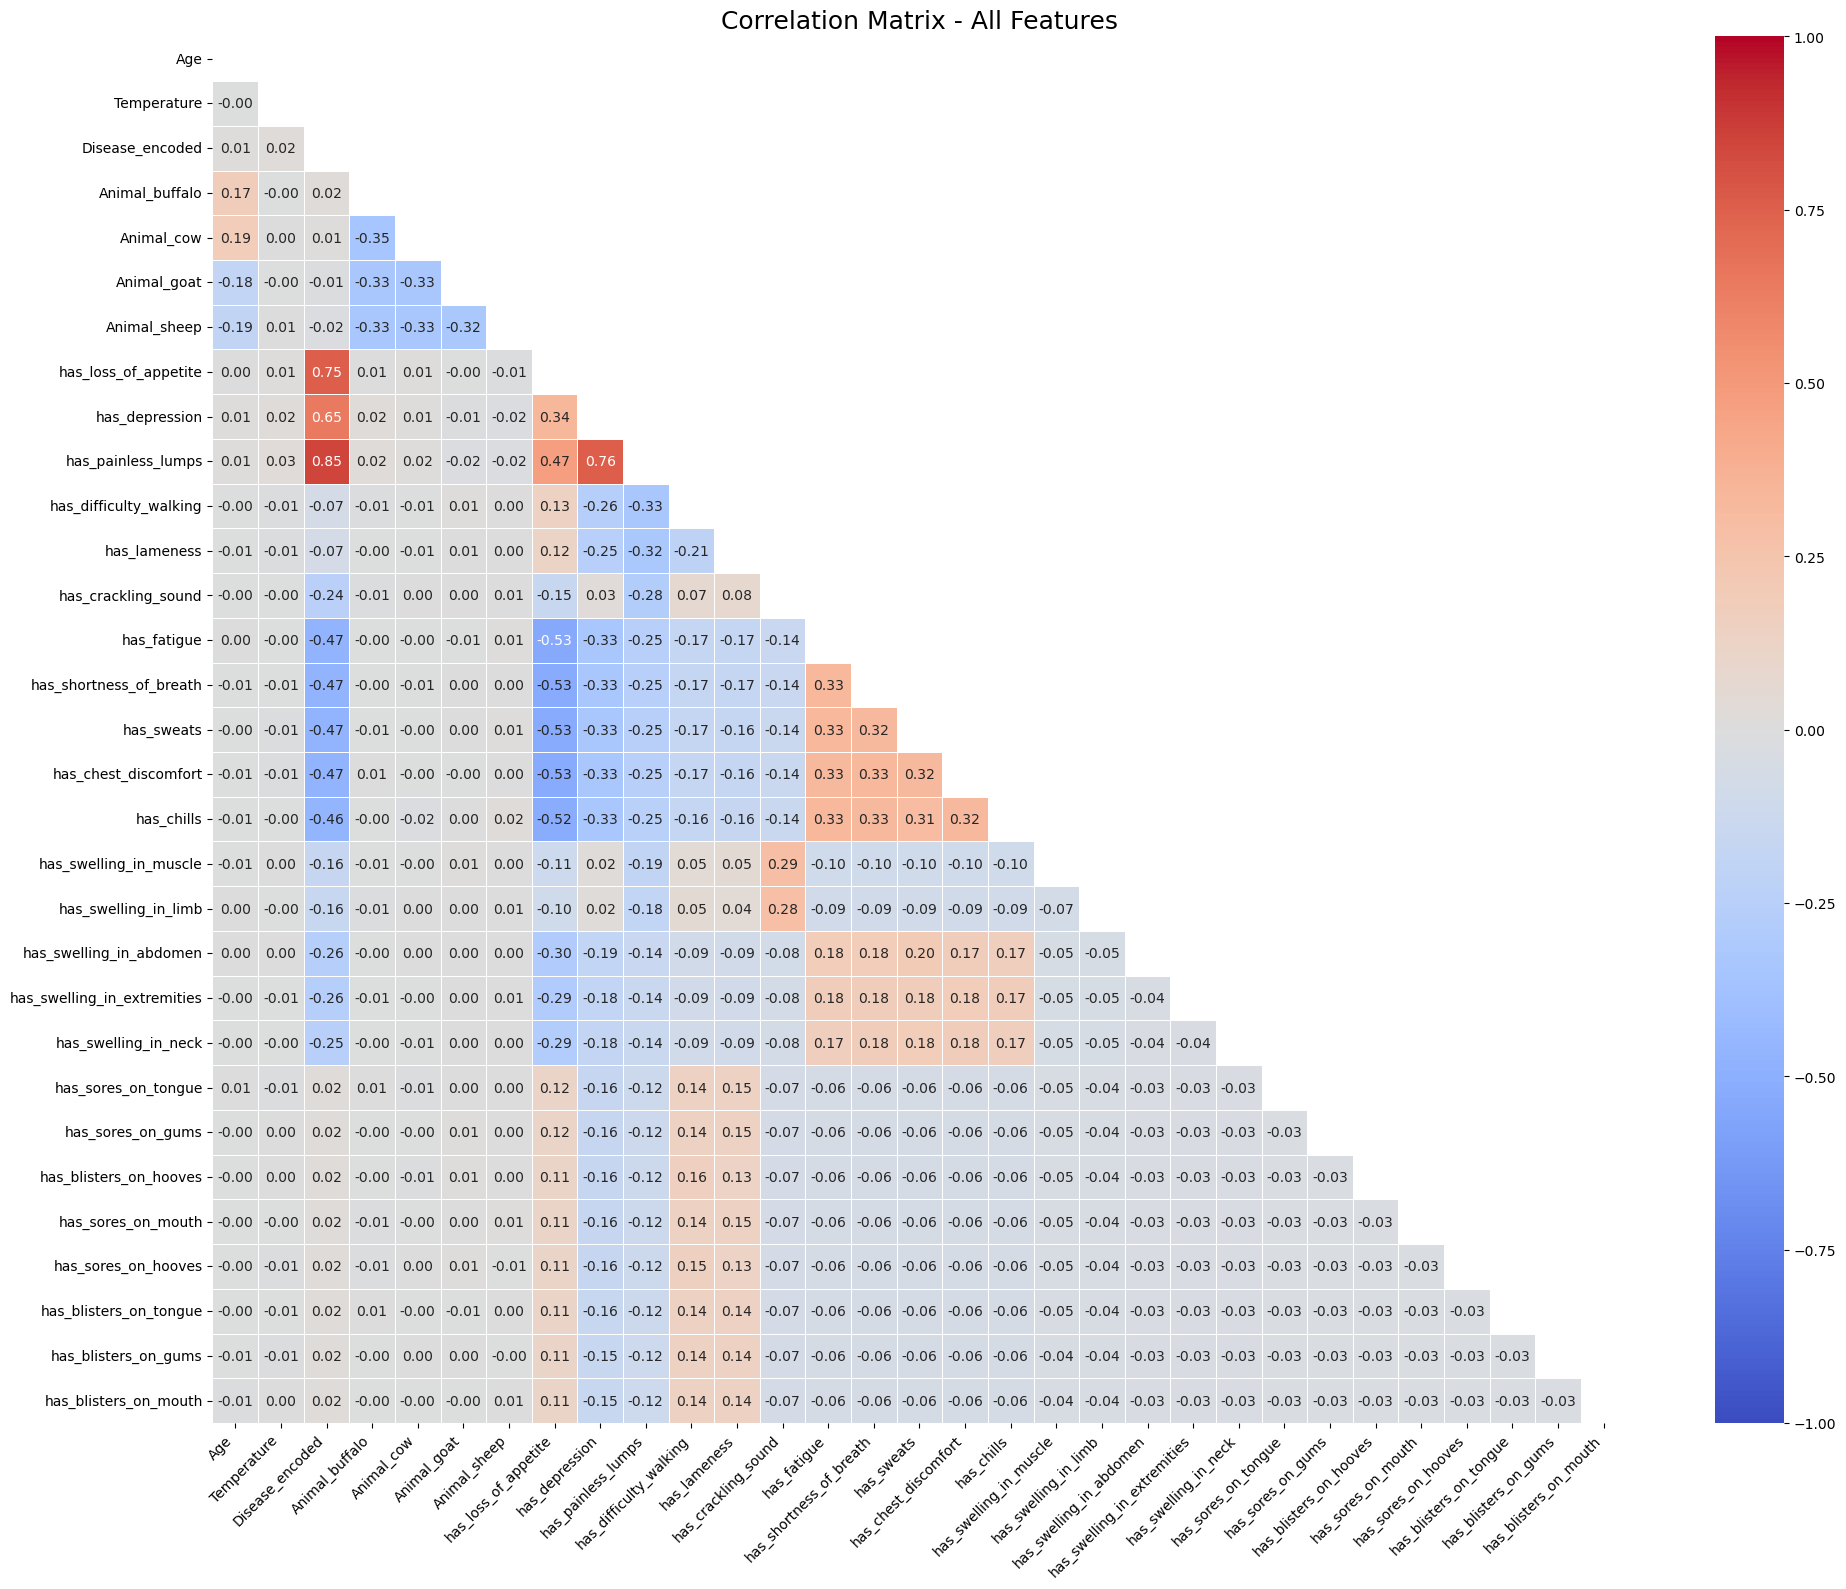

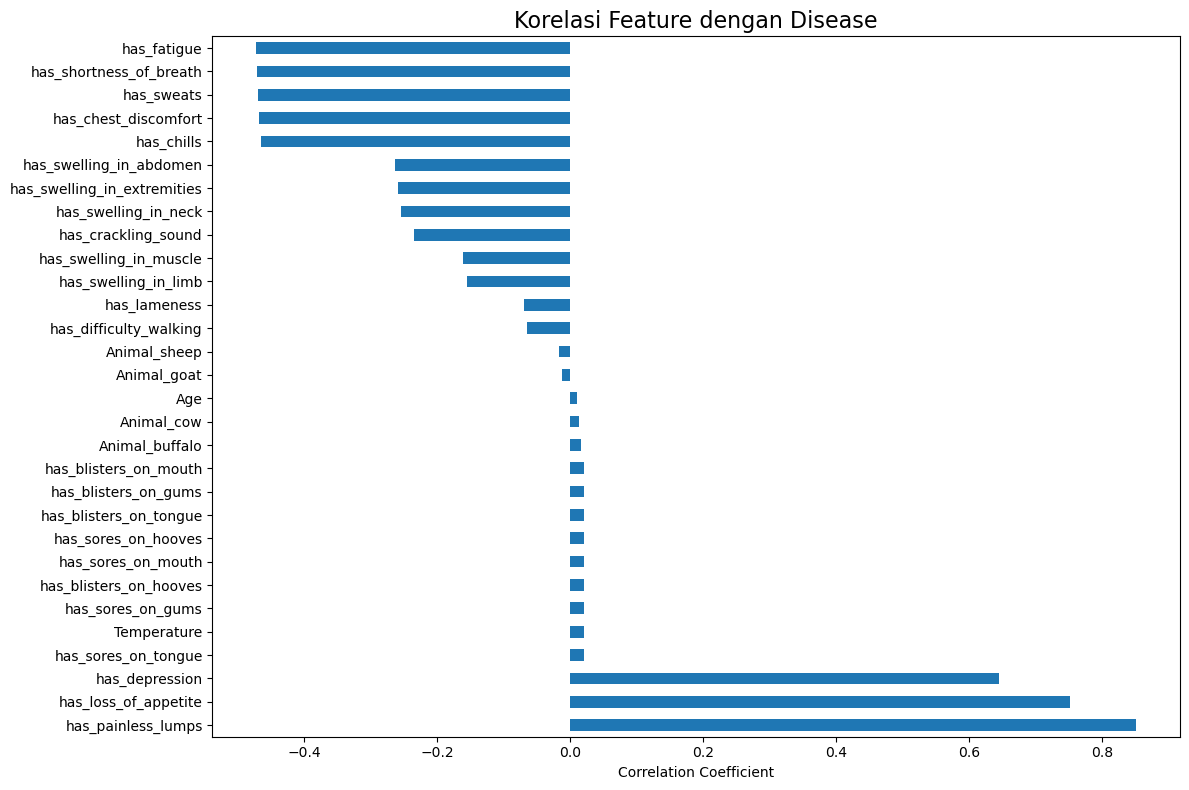

In [27]:
plt.figure(figsize=(10, 8))
numeric_corr = df[['Age', 'Temperature']].corr()
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix - Fitur Numerik', fontsize=16)
plt.tight_layout()
plt.show()

df_encoded = df.copy()

# Label encoding untuk target variable (Disease)
le = LabelEncoder()
df_encoded['Disease_encoded'] = le.fit_transform(df_encoded['Disease'])

# One-hot encoding untuk Animal
animal_dummies = pd.get_dummies(df_encoded['Animal'], prefix='Animal')
df_encoded = pd.concat([df_encoded, animal_dummies], axis=1)

# Menggunakan pendekatan frequency encoding untuk gejala
symptom_cols = ['Symptom_1', 'Symptom_2', 'Symptom_3']

# Membuat dictionary untuk memetakan setiap gejala dengan frekuensinya
symptom_freq = {}
for col in symptom_cols:
    for symptom, count in df_encoded[col].value_counts().items():
        if symptom in symptom_freq:
            symptom_freq[symptom] += count
        else:
            symptom_freq[symptom] = count

top_symptoms = sorted(symptom_freq.items(), key=lambda x: x[1], reverse=True)[:24]
for symptom, _ in top_symptoms:
    df_encoded[f'has_{symptom.replace(" ", "_")}'] = df_encoded[symptom_cols].apply(
        lambda row: int(symptom in row.values), axis=1
    )

features_for_corr = ['Age', 'Temperature', 'Disease_encoded'] + \
                    list(animal_dummies.columns) + \
                    [col for col in df_encoded.columns if col.startswith('has_')]

corr_matrix = df_encoded[features_for_corr].corr()

plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, 
            fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix - All Features', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

target_corr = corr_matrix['Disease_encoded'].sort_values(ascending=False)
plt.figure(figsize=(12, 8))
target_corr.drop('Disease_encoded').plot(kind='barh')
plt.title('Korelasi Feature dengan Disease', fontsize=16)
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

- Has_painless_lumps memiliki korelasi positif tertinggi (+0,8), menunjukkan gejala ini sangat prediktif untuk penyakit tertentu (kemungkinan lumpy virus).

- Has_loss_of_appetite (+0,7) merupakan indikator kuat kedua untuk diagnosis, meskipun merupakan gejala umum pada beberapa penyakit.

- Has_depression (+0,6) juga menunjukkan korelasi positif yang kuat dengan diagnosis penyakit tertentu.

- Gejala pernapasan (shortness_of_breath, chest_discomfort) menunjukkan korelasi negatif (-0,3), yang berarti keberadaannya cenderung mengindikasikan penyakit spesifik (kemungkinan anthrax).

- Gejala sistemik (fatigue, sweats, chills) juga berkorelasi negatif (-0,3), menandakan karakteristik penyakit tertentu.

- Pembengkakan pada berbagai area tubuh (abdomen, extremities, neck) memiliki korelasi negatif moderat (-0,25).

- Crackling_sound menunjukkan korelasi negatif (-0,2), yang konsisten dengan karakteristik khas blackleg.

- Jenis hewan (buffalo, cow, goat, sheep) memiliki korelasi sangat rendah, menunjukkan bahwa penyakit tidak spesifik pada jenis hewan tertentu.

- Umur dan temperatur menunjukkan korelasi minimal, mengindikasikan bahwa faktor ini kurang signifikan untuk diagnosis dibanding gejala klinis.

- Lesi pada mulut dan kaki (blisters, sores) memiliki korelasi rendah, meskipun merupakan ciri khas foot and mouth disease, menunjukkan gejala ini mungkin sensitif tapi tidak spesifik.

## 3. Data Preparation

### 3.1 Feature Encoding 

#### 3.1.1 Label Encoding untuk Target Variable

In [28]:
le_disease = LabelEncoder()
df['Disease_encoded'] = le_disease.fit_transform(df['Disease'])

disease_mapping = dict(zip(le_disease.classes_, le_disease.transform(le_disease.classes_)))
print("Mapping Disease ke nilai numerik:")
for disease, code in disease_mapping.items():
    print(f"{disease}: {code}")
    
df[['Disease', 'Disease_encoded']].drop_duplicates().sort_values('Disease_encoded')

Mapping Disease ke nilai numerik:
anthrax: 0
blackleg: 1
foot and mouth: 2
lumpy virus: 3
pneumonia: 4


,Disease,Disease_encoded
12,anthrax,0
3,blackleg,1
5,foot and mouth,2
1,lumpy virus,3
0,pneumonia,4


#### 3.1.2 One-Hot Encoding untuk Variabel Animal

In [29]:
animal_dummies = pd.get_dummies(df['Animal'], prefix='Animal')
print("Hasil One-Hot Encoding untuk Animal:")
animal_dummies.head()

Hasil One-Hot Encoding untuk Animal:


,Animal_buffalo,Animal_cow,Animal_goat,Animal_sheep
0,False,True,False,False
1,True,False,False,False
2,False,False,False,True
3,False,True,False,False
4,False,False,False,True


#### 3.1.3 Encoding untuk Fitur Symptoms

Karena kolom Symptom memiliki banyak nilai unik dan setiap hewan memiliki 3 gejala yang tercatat pada 3 kolom terpisah, pendekatan biner (has_symptom) akan lebih efisien daripada one-hot encoding standar.

In [30]:
symptom_cols = ['Symptom_1', 'Symptom_2', 'Symptom_3']
all_symptoms = set()

for col in symptom_cols:
    all_symptoms.update(df[col].unique())

print(f"Total gejala unik: {len(all_symptoms)}")
print(f"Contoh gejala: {list(all_symptoms)[:5]}")

Total gejala unik: 24
Contoh gejala: ['blisters on tongue', 'difficulty walking', 'swelling in limb', 'sores on mouth', 'loss of appetite']


In [31]:
# has_symptom = 1 jika hewan memiliki gejala tersebut, 0 jika tidak

symptom_features = pd.DataFrame()

for symptom in all_symptoms:
    feature_name = f"has_{symptom.replace(' ', '_')}"
    symptom_features[feature_name] = df[symptom_cols].apply(
        lambda row: int(symptom in row.values), axis=1
    )

print(f"Dimensi fitur gejala: {symptom_features.shape}")
symptom_features.head()

Dimensi fitur gejala: (43778, 24)


,has_blisters_on_tongue,has_difficulty_walking,has_swelling_in_limb,has_sores_on_mouth,has_loss_of_appetite,has_sweats,has_blisters_on_hooves,has_painless_lumps,has_lameness,has_crackling_sound,...,has_shortness_of_breath,has_chest_discomfort,has_blisters_on_gums,has_depression,has_swelling_in_abdomen,has_swelling_in_extremities,has_fatigue,has_blisters_on_mouth,has_swelling_in_muscle,has_sores_on_hooves
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


### 3.2 Feature Engginering

Mengelompokan Gejala(Symptoms) Menjadi Syndrome

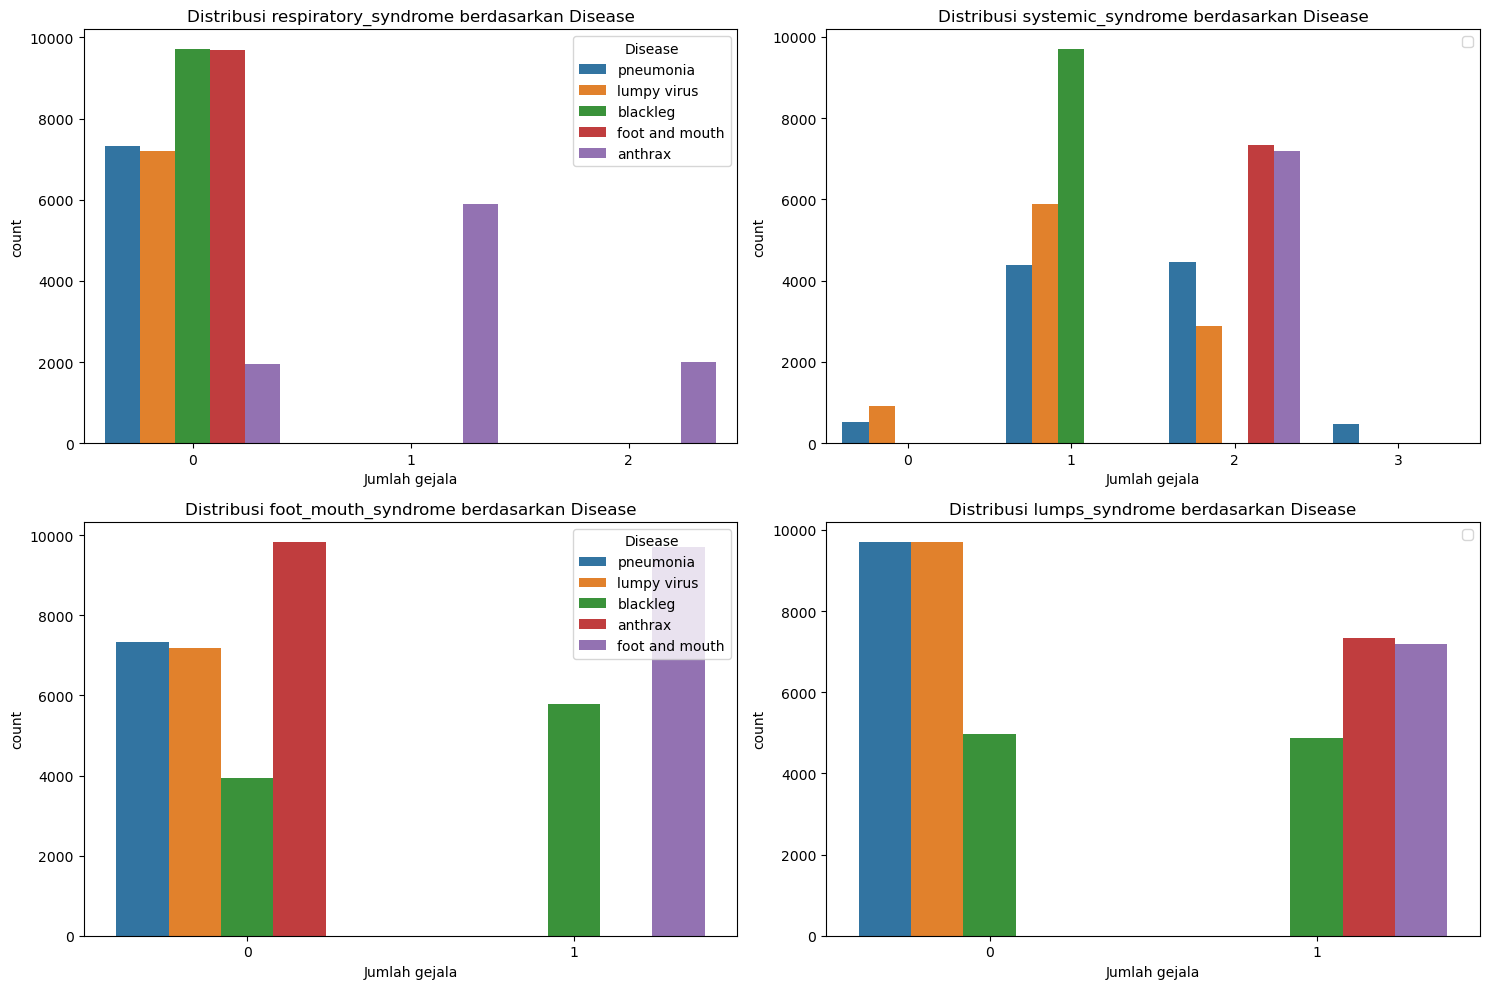

In [32]:

respiratory_symptoms = ['shortness of breath', 'chest discomfort', 'coughing', 'rapid breathing']
df['respiratory_syndrome'] = df[symptom_cols].apply(
    lambda row: sum(1 for symptom in row if symptom in respiratory_symptoms), axis=1
)

systemic_symptoms = ['fatigue', 'sweats', 'chills', 'fever', 'depression', 'loss of appetite']
df['systemic_syndrome'] = df[symptom_cols].apply(
    lambda row: sum(1 for symptom in row if symptom in systemic_symptoms), axis=1
)

foot_mouth_symptoms = ['difficulty walking', 'lameness', 'blisters', 'sores', 'drooling']
df['foot_mouth_syndrome'] = df[symptom_cols].apply(
    lambda row: sum(1 for symptom in row if symptom in foot_mouth_symptoms), axis=1
)

lumps_symptoms = ['painless lumps', 'painful lumps', 'swelling in neck', 
                  'swelling in extremities', 'swelling in abdomen']
df['lumps_syndrome'] = df[symptom_cols].apply(
    lambda row: sum(1 for symptom in row if symptom in lumps_symptoms), axis=1
)

plt.figure(figsize=(15, 10))
for i, syndrome in enumerate(['respiratory_syndrome', 'systemic_syndrome', 
                             'foot_mouth_syndrome', 'lumps_syndrome']):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=syndrome, hue='Disease', data=df)
    plt.title(f'Distribusi {syndrome} berdasarkan Disease')
    plt.xlabel('Jumlah gejala')
    plt.xticks(rotation=0)
    if i == 1 or i == 3:
        plt.legend([])
    else:
        plt.legend(title='Disease', loc='upper right')

plt.tight_layout()
plt.show()

### 3.3 Feature Selection

In [33]:
prepared_features = pd.concat([
    df[['Age', 'Temperature', 'respiratory_syndrome', 'systemic_syndrome', 'foot_mouth_syndrome', 'lumps_syndrome']],
    animal_dummies,
    symptom_features
], axis=1)

print(f"Dimensi data dengan semua fitur: {prepared_features.shape}")

Dimensi data dengan semua fitur: (43778, 34)


#### 3.3.1 Mutual Information Score

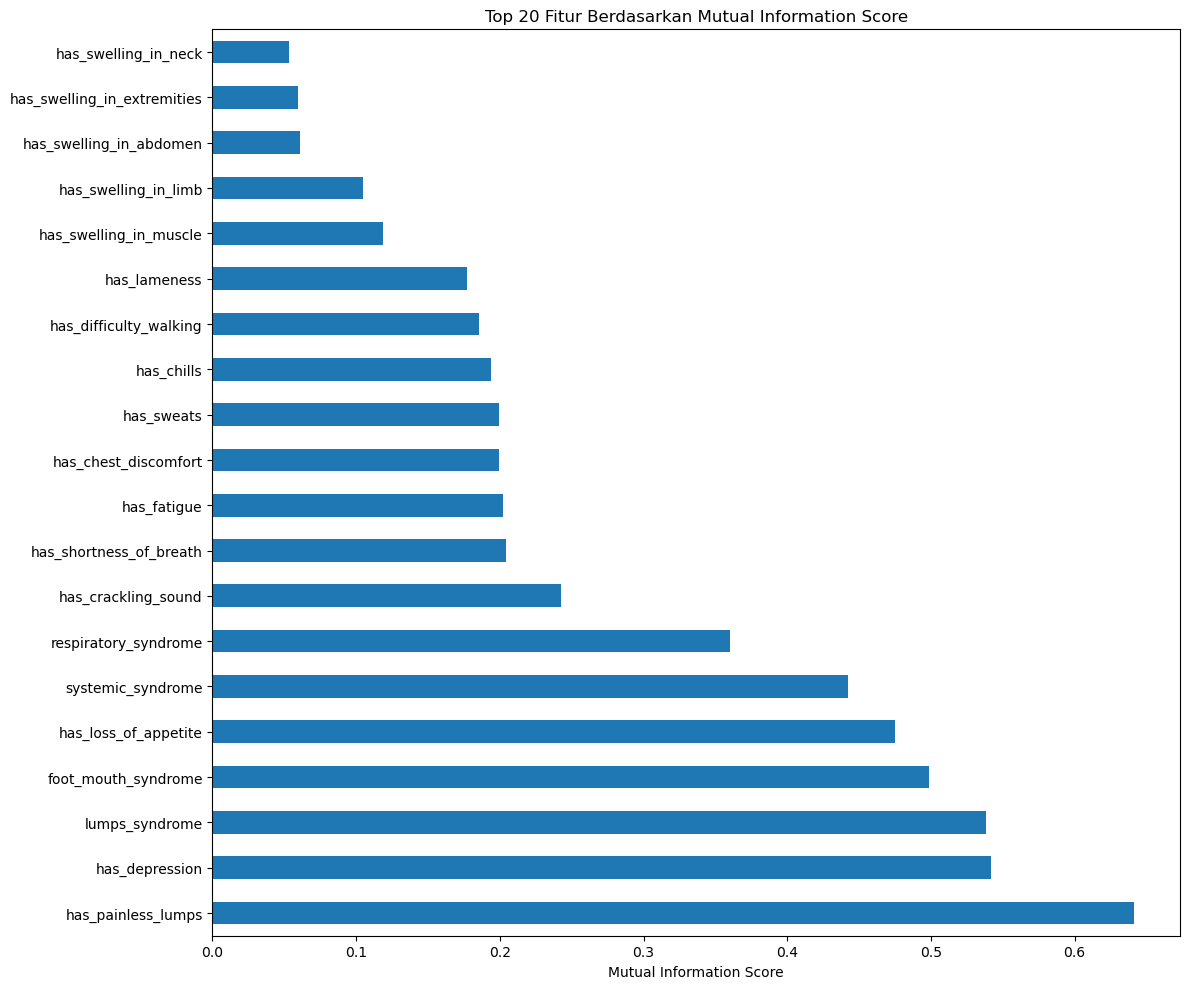

In [34]:
X = prepared_features
y = df['Disease_encoded']

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

plt.figure(figsize=(12, 10))
mi_scores.head(20).plot.barh()
plt.title('Top 20 Fitur Berdasarkan Mutual Information Score')
plt.xlabel('Mutual Information Score')
plt.tight_layout()
plt.show()

#### 3.3.2 Chi-Square Test

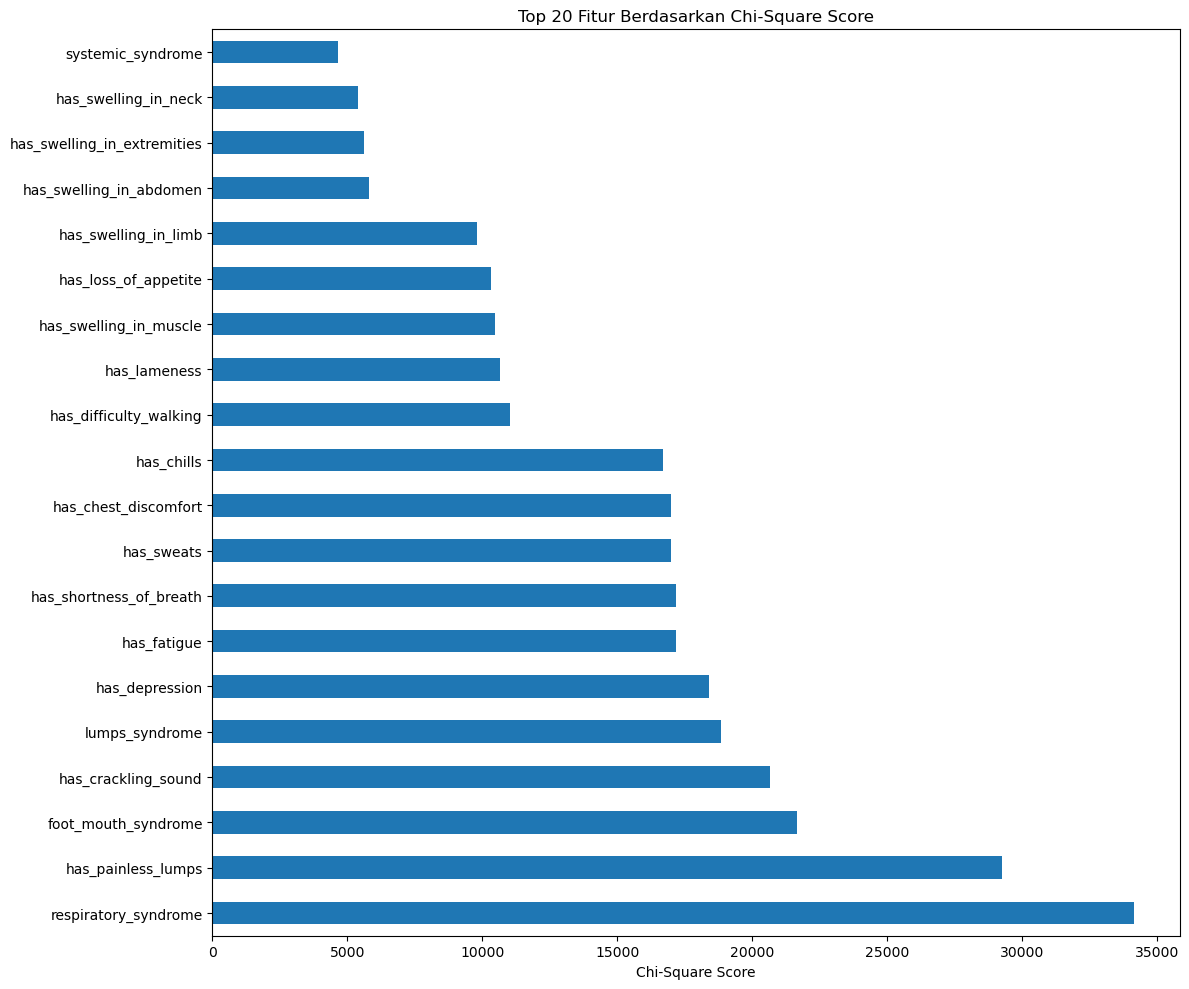

Top 20 Fitur Berdasarkan Chi-Square:
                               chi2_score  p_value  mi_score
respiratory_syndrome         34139.436700      0.0  0.360110
has_painless_lumps           29256.000000      0.0  0.641316
foot_mouth_syndrome          21678.496515      0.0  0.498817
has_crackling_sound          20643.116442      0.0  0.242262
lumps_syndrome               18831.210035      0.0  0.538223
has_depression               18418.477000      0.0  0.541614
has_fatigue                  17178.332859      0.0  0.202059
has_shortness_of_breath      17161.092461      0.0  0.203989
has_sweats                   16985.240398      0.0  0.199545
has_chest_discomfort         16978.344239      0.0  0.199661
has_chills                   16709.394026      0.0  0.194175
has_difficulty_walking       11039.988522      0.0  0.185830
has_lameness                 10643.813400      0.0  0.176805
has_swelling_in_muscle       10468.858746      0.0  0.118399
has_loss_of_appetite         10303.414652      0

In [35]:
chi2_scores, p_values = chi2(X, y)
chi2_scores = pd.Series(chi2_scores, index=X.columns)
p_values = pd.Series(p_values, index=X.columns)

feature_selection_df = pd.DataFrame({
    'chi2_score': chi2_scores,
    'p_value': p_values,
    'mi_score': mi_scores
}).sort_values('chi2_score', ascending=False)

plt.figure(figsize=(12, 10))
feature_selection_df['chi2_score'].head(20).plot.barh()
plt.title('Top 20 Fitur Berdasarkan Chi-Square Score')
plt.xlabel('Chi-Square Score')
plt.tight_layout()
plt.show()

print("Top 20 Fitur Berdasarkan Chi-Square:")
print(feature_selection_df.head(20))

#### 3.3.3 Seleksi Fitur Final

Berdasarkan analisis di atas, kita akan memilih fitur-fitur yang memiliki skor tinggi baik dari mutual information maupun chi-square test.

In [36]:
significant_features = feature_selection_df[feature_selection_df['p_value'] < 0.05].index.tolist()
print(f"Jumlah fitur yang signifikan: {len(significant_features)}")

top_features = mi_scores.sort_values(ascending=False).head(30).index.tolist()
print(f"Top 30 fitur berdasarkan mutual information: {len(top_features)}")

selected_syndrome_features = ['respiratory_syndrome', 'systemic_syndrome', 
                             'foot_mouth_syndrome', 'lumps_syndrome', 
                             'Age', 'Temperature']

final_features = list(set(top_features + selected_syndrome_features))
print(f"Jumlah fitur final: {len(final_features)}")
print("Contoh fitur yang dipilih:", final_features[:10])

X_selected = X[final_features]

Jumlah fitur yang signifikan: 32
Top 30 fitur berdasarkan mutual information: 30
Jumlah fitur final: 31
Contoh fitur yang dipilih: ['has_chest_discomfort', 'has_sores_on_mouth', 'has_swelling_in_limb', 'Animal_cow', 'has_swelling_in_abdomen', 'systemic_syndrome', 'has_chills', 'has_shortness_of_breath', 'has_blisters_on_hooves', 'has_swelling_in_neck']


### 3.4 Train & Test Split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.25, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nDistribusi kelas di training set:")
print(pd.Series(y_train).value_counts(normalize=True).round(3) * 100)

print("\nDistribusi kelas di testing set:")
print(pd.Series(y_test).value_counts(normalize=True).round(3) * 100)

X_train shape: (32833, 31)
X_test shape: (10945, 31)
y_train shape: (32833,)
y_test shape: (10945,)

Distribusi kelas di training set:
Disease_encoded
0    22.5
1    22.2
2    22.2
4    16.7
3    16.4
Name: proportion, dtype: float64

Distribusi kelas di testing set:
Disease_encoded
0    22.5
1    22.2
2    22.2
4    16.7
3    16.4
Name: proportion, dtype: float64


### 3.5 Feature Scaling

Menerapkan scaling pada fitur numerik agar semua fitur berkontribusi secara setara pada model.

In [38]:
numeric_features = ['Age', 'Temperature']
numeric_features = [f for f in numeric_features if f in final_features]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if numeric_features:
    X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

if numeric_features:
    comparison = pd.DataFrame({
        'Before_Scaling': X_train[numeric_features].mean(),
        'After_Scaling': X_train_scaled[numeric_features].mean()
    })
    print("Perbandingan rata-rata sebelum dan sesudah scaling:")
    print(comparison)
    
    comparison_std = pd.DataFrame({
        'Before_Scaling': X_train[numeric_features].std(),
        'After_Scaling': X_train_scaled[numeric_features].std()
    })
    print("\nPerbandingan standar deviasi sebelum dan sesudah scaling:")
    print(comparison_std)

Perbandingan rata-rata sebelum dan sesudah scaling:
             Before_Scaling  After_Scaling
Age                6.760515   4.279531e-17
Temperature      102.267749  -1.107195e-14

Perbandingan standar deviasi sebelum dan sesudah scaling:
             Before_Scaling  After_Scaling
Age                3.887802       1.000015
Temperature        1.402329       1.000015


### 3.6 Handle Class Imbalance

Memeriksa keseimbangan kelas penyakit dan menerapkan teknik resampling jika diperlukan.

Distribusi kelas sebelum resampling:
Disease_encoded
0    7381
1    7285
2    7276
4    5497
3    5394
Name: count, dtype: int64


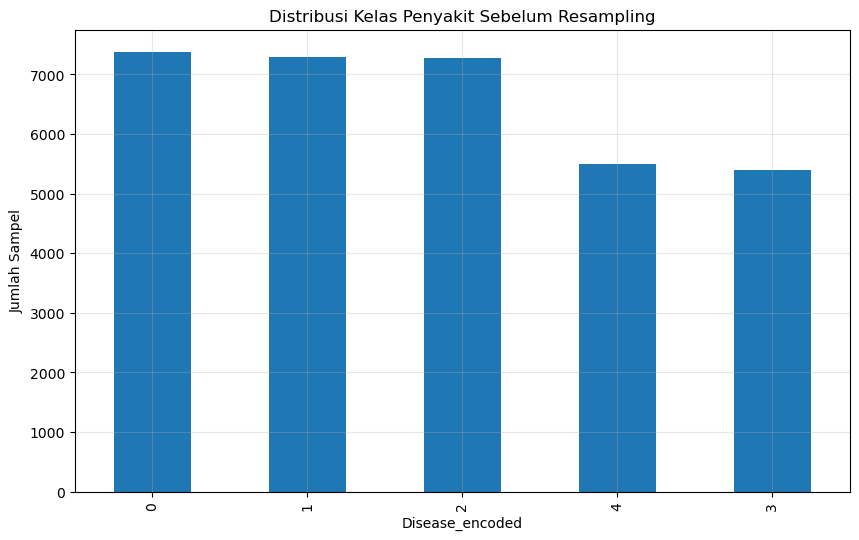


Rasio ketidakseimbangan (max/min): 1.37
Distribusi kelas cukup seimbang, tidak perlu resampling.


In [39]:
class_distribution = pd.Series(y_train).value_counts()
print("Distribusi kelas sebelum resampling:")
print(class_distribution)

plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Distribusi Kelas Penyakit Sebelum Resampling')
plt.ylabel('Jumlah Sampel')
plt.grid(True, alpha=0.3)
plt.show()

imbalance_ratio = class_distribution.max() / class_distribution.min()
print(f"\nRasio ketidakseimbangan (max/min): {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    print("Terdapat ketidakseimbangan kelas, menerapkan SMOTE...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    resampled_distribution = pd.Series(y_train_resampled).value_counts()
    print("\nDistribusi kelas setelah resampling:")
    print(resampled_distribution)
    
    plt.figure(figsize=(10, 6))
    resampled_distribution.plot(kind='bar')
    plt.title('Distribusi Kelas Penyakit Setelah Resampling')
    plt.ylabel('Jumlah Sampel')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    X_train_final = X_train_resampled
    y_train_final = y_train_resampled
else:
    print("Distribusi kelas cukup seimbang, tidak perlu resampling.")
    X_train_final = X_train_scaled
    y_train_final = y_train

### 3.7 Data Validation

Melakukan verifikasi akhir data yang telah dipersiapkan untuk modeling.

In [40]:
print(f"Missing values di X_train_final: {X_train_final.isna().sum().sum()}")
print(f"Missing values di X_test_scaled: {X_test_scaled.isna().sum().sum()}")

print(f"\nDimensi akhir X_train_final: {X_train_final.shape}")
print(f"Dimensi akhir y_train_final: {y_train_final.shape}")
print(f"Dimensi akhir X_test_scaled: {X_test_scaled.shape}")
print(f"Dimensi akhir y_test: {y_test.shape}")

if numeric_features:
    numeric_summary = pd.DataFrame({
        'Train_Min': X_train_final[numeric_features].min(),
        'Train_Max': X_train_final[numeric_features].max(),
        'Test_Min': X_test_scaled[numeric_features].min(),
        'Test_Max': X_test_scaled[numeric_features].max()
    })
    print("\nRange nilai fitur numerik:")
    print(numeric_summary)

feature_names = list(X_train_final.columns)
print(f"\nFeature names yang akan digunakan ({len(feature_names)} fitur):")
print(feature_names[:10], "...")

Missing values di X_train_final: 0
Missing values di X_test_scaled: 0

Dimensi akhir X_train_final: (32833, 31)
Dimensi akhir y_train_final: (32833,)
Dimensi akhir X_test_scaled: (10945, 31)
Dimensi akhir y_test: (10945,)

Range nilai fitur numerik:
             Train_Min  Train_Max  Test_Min  Test_Max
Age          -1.481712   2.119349 -1.481712  2.119349
Temperature  -1.617155   1.948396 -1.617155  1.948396

Feature names yang akan digunakan (31 fitur):
['has_chest_discomfort', 'has_sores_on_mouth', 'has_swelling_in_limb', 'Animal_cow', 'has_swelling_in_abdomen', 'systemic_syndrome', 'has_chills', 'has_shortness_of_breath', 'has_blisters_on_hooves', 'has_swelling_in_neck'] ...


## 4. Modeling

Saya akan mengimplementasikan dua jenis model klasifikasi yang berbeda:

1. **Random Forest**: Sebuah metode ensemble learning berdasarkan decision tree yang berfungsi baik dengan data kategorikal dan memberikan kepentingan fitur (feature importance).
2. **XGBoost**: Sebuah algoritma gradient boosting yang sering kali memberikan kinerja terbaik pada data terstruktur.

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    n_classes = len(np.unique(y_test))
    roc_auc = {}
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr, tpr)
    
    avg_roc_auc = sum(roc_auc.values()) / len(roc_auc)
    
    print(f"\n===== {model_name} Evaluation =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average ROC AUC: {avg_roc_auc:.4f}")
    
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, target_names=le_disease.classes_)
    print(report)
    
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le_disease.classes_, 
                yticklabels=le_disease.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': avg_roc_auc,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    return metrics

### 4.1 Boosting Algorithm: XGBoost

XGBoost (eXtreme Gradient Boosting) adalah implementasi dari gradient boosted decision trees yang dirancang untuk kecepatan dan kinerja. Algoritma ini sangat efektif untuk:

- Menangani fitur kategorikal (seperti jenis hewan dan gejala kita)
- Bekerja dengan data yang tidak seimbang
- Menangkap pola kompleks dalam data
- Mencegah overfitting melalui regularisasi

Training XGBoost model...
XGBoost training completed in 0.96 seconds

===== XGBoost Evaluation =====
Accuracy: 0.8285
Precision: 0.8281
Recall: 0.8285
F1 Score: 0.8275
Average ROC AUC: 0.9573

Classification Report:
                precision    recall  f1-score   support

       anthrax       1.00      1.00      1.00      2461
      blackleg       1.00      1.00      1.00      2428
foot and mouth       1.00      1.00      1.00      2425
   lumpy virus       0.47      0.40      0.44      1798
     pneumonia       0.49      0.56      0.52      1833

      accuracy                           0.83     10945
     macro avg       0.79      0.79      0.79     10945
  weighted avg       0.83      0.83      0.83     10945



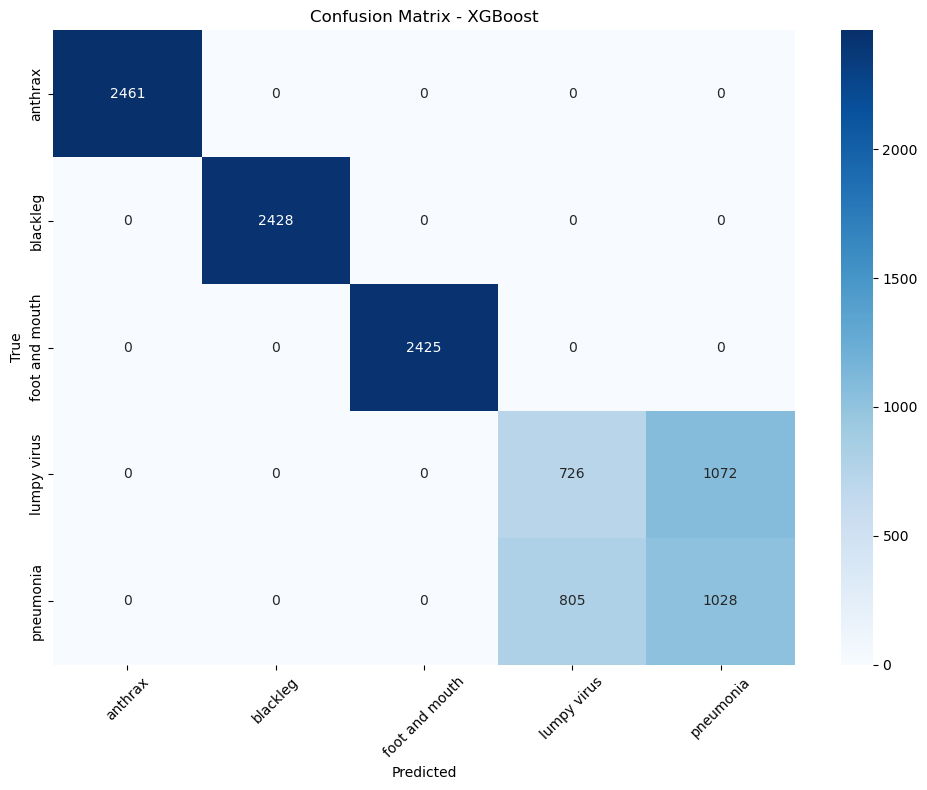

In [45]:
xgb_model = XGBClassifier(
    objective='multi:softprob',
    n_estimators=100,          
    learning_rate=0.1,         
    max_depth=5,               
    min_child_weight=1,        
    gamma=0,                   
    subsample=0.8,             
    colsample_bytree=0.8,      
    random_state=42            
)

print("Training XGBoost model...")
start_time = datetime.now()
xgb_model.fit(X_train_final, y_train_final)
end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()
print(f"XGBoost training completed in {training_time:.2f} seconds")

xgb_metrics = evaluate_model(xgb_model, X_train_final, y_train_final, 
                             X_test_scaled, y_test, "XGBoost")

## 4.2 Random Forest Model

Random Forest adalah metode ensemble learning yang membangun beberapa decision tree dan menggabungkan prediksinya. Metode ini sangat cocok untuk tugas klasifikasi multi-class ini karena:

- Menangani fitur kategorikal dengan baik tanpa memerlukan preprocessing yang ekstensif.
- Tahan terhadap overfitting melalui penggunaan bagging (bootstrap aggregation).
- Menyediakan ukuran kepentingan fitur (feature importance) yang membantu mengidentifikasi gejala mana yang paling prediktif.
- Secara umum berkinerja baik dengan campuran jenis fitur.

Training Random Forest model...
Random Forest training completed in 0.52 seconds

===== Random Forest Evaluation =====
Accuracy: 0.8147
Precision: 0.8146
Recall: 0.8147
F1 Score: 0.8146
Average ROC AUC: 0.9527

Classification Report:
                precision    recall  f1-score   support

       anthrax       1.00      1.00      1.00      2461
      blackleg       1.00      1.00      1.00      2428
foot and mouth       1.00      1.00      1.00      2425
   lumpy virus       0.43      0.41      0.42      1798
     pneumonia       0.45      0.47      0.46      1833

      accuracy                           0.81     10945
     macro avg       0.78      0.78      0.78     10945
  weighted avg       0.81      0.81      0.81     10945



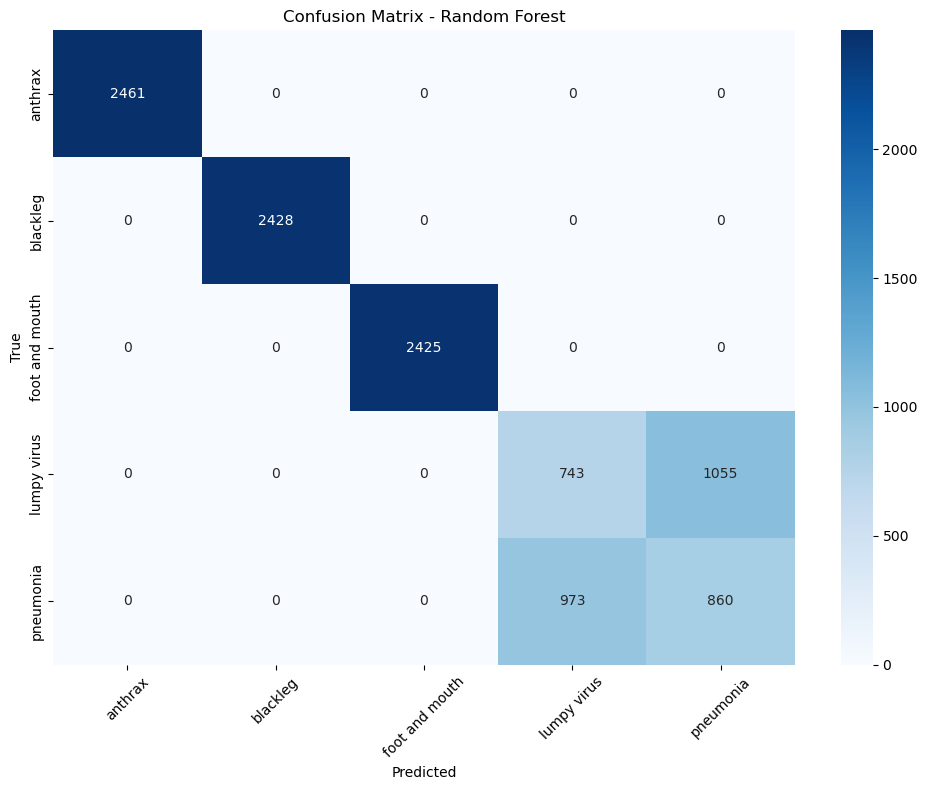

In [48]:
rf_model = RandomForestClassifier(
    n_estimators=100,      
    max_depth=None,        
    min_samples_split=2,   
    min_samples_leaf=1,    
    max_features='sqrt',   
    bootstrap=True,        
    random_state=42,       
    n_jobs=-1              
)

print("Training Random Forest model...")
start_time = datetime.now()
rf_model.fit(X_train_final, y_train_final)
end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()
print(f"Random Forest training completed in {training_time:.2f} seconds")

rf_metrics = evaluate_model(rf_model, X_train_final, y_train_final, 
                           X_test_scaled, y_test, "Random Forest")

## 5. Model Evaluation

Komparasi kedua model

Model Performance Comparison:
            XGBoost  Random Forest
Accuracy   0.828506       0.814710
Precision  0.828132       0.814589
Recall     0.828506       0.814710
F1 Score   0.827450       0.814575
ROC AUC    0.957291       0.952655


<Figure size 1200x600 with 0 Axes>

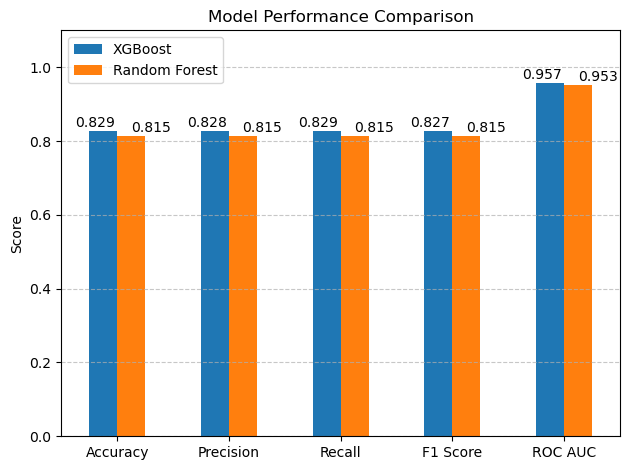


Per-Class Performance Comparison:
                XGBoost Precision  RF Precision  XGBoost Recall  RF Recall  \
Disease                                                                      
anthrax                  1.000000      1.000000        1.000000   1.000000   
blackleg                 1.000000      1.000000        1.000000   1.000000   
foot and mouth           1.000000      1.000000        1.000000   1.000000   
lumpy virus              0.474200      0.432984        0.403782   0.413237   
pneumonia                0.489524      0.449086        0.560829   0.469176   

                XGBoost F1     RF F1  
Disease                               
anthrax           1.000000  1.000000  
blackleg          1.000000  1.000000  
foot and mouth    1.000000  1.000000  
lumpy virus       0.436167  0.422880  
pneumonia         0.522756  0.458911  


<Figure size 1200x600 with 0 Axes>

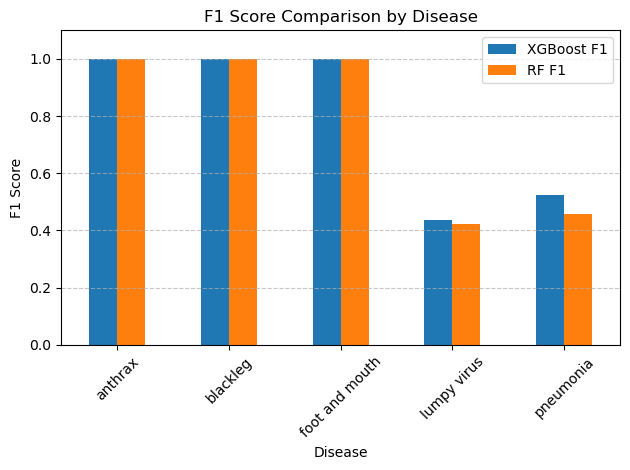

In [49]:
models_comparison = pd.DataFrame({
    'XGBoost': [
        xgb_metrics['accuracy'],
        xgb_metrics['precision'],
        xgb_metrics['recall'],
        xgb_metrics['f1_score'],
        xgb_metrics['roc_auc']
    ],
    'Random Forest': [
        rf_metrics['accuracy'],
        rf_metrics['precision'],
        rf_metrics['recall'],
        rf_metrics['f1_score'],
        rf_metrics['roc_auc']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

print("Model Performance Comparison:")
print(models_comparison)

plt.figure(figsize=(12, 6))
models_comparison.plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
for i in range(len(models_comparison)):
    for j in range(len(models_comparison.columns)):
        plt.text(i + j/len(models_comparison.columns) - 0.2, 
                 models_comparison.iloc[i, j] + 0.01,
                 f'{models_comparison.iloc[i, j]:.3f}',
                 ha='center')
plt.tight_layout()
plt.show()


from sklearn.metrics import classification_report
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)

report_xgb = classification_report(y_test, y_pred_xgb, 
                                  target_names=le_disease.classes_, 
                                  output_dict=True)
report_rf = classification_report(y_test, y_pred_rf, 
                                 target_names=le_disease.classes_, 
                                 output_dict=True)

per_class_comparison = []

for disease in le_disease.classes_:
    per_class_comparison.append({
        'Disease': disease,
        'XGBoost Precision': report_xgb[disease]['precision'],
        'RF Precision': report_rf[disease]['precision'],
        'XGBoost Recall': report_xgb[disease]['recall'],
        'RF Recall': report_rf[disease]['recall'],
        'XGBoost F1': report_xgb[disease]['f1-score'],
        'RF F1': report_rf[disease]['f1-score']
    })

per_class_df = pd.DataFrame(per_class_comparison)
per_class_df = per_class_df.set_index('Disease')

print("\nPer-Class Performance Comparison:")
print(per_class_df)

plt.figure(figsize=(12, 6))
per_class_df[['XGBoost F1', 'RF F1']].plot(kind='bar')
plt.title('F1 Score Comparison by Disease')
plt.ylabel('F1 Score')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Analisis Perbandingan Model: XGBoost vs Random Forest**

Metrik Performa Keseluruhan

- **Akurasi**: XGBoost unggul dengan 82,9% dibanding RF yang mencapai 81,5% (+1,4%)
- **Presisi & Recall**: XGBoost secara konsisten mempertahankan keunggulan sekitar ~1,3% 
- **Skor F1**: XGBoost (82,7%) mengungguli RF (81,5%) sebesar 1,2%
- **ROC AUC**: Kedua model menunjukkan performa tinggi (XGBoost: 95,7%, RF: 95,3%)

Performa Per-Disease

- **Klasifikasi Sempurna (F1=1,0)**: Kedua model mencapai akurasi 100% untuk:
  - Anthrax
  - Blackleg
  - Foot and mouth disease

- **Deteksi Lumpy Virus**:
  - XGBoost sedikit lebih baik (F1: 0,436 vs 0,423)
  - Keduanya mengalami kesulitan dalam presisi (~43-47%)
  - Tingkat recall yang rendah (~40-41%)

- **Deteksi Pneumonia**:
  - XGBoost secara signifikan mengungguli RF (F1: 0,523 vs 0,459)
  - Recall yang lebih tinggi pada XGBoost (56,1% vs 46,9%) menunjukkan kemampuan deteksi yang lebih baik
  - Keduanya menunjukkan tantangan presisi yang serupa (~45-49%)

### **Kesimpulan**
**XGBoost adalah model superior untuk prediksi penyakit pada ternak**, menunjukkan performa yang lebih baik pada semua metrik. Model ini khususnya unggul dalam:

1. Akurasi keseluruhan yang lebih tinggi dan performa yang seimbang (presisi/recall)
2. Kemampuan deteksi pneumonia yang jauh lebih baik
3. Performa yang sedikit lebih baik dalam mendeteksi lumpy virus
4. Performa sempurna yang setara pada tiga penyakit yang mudah dibedakan

Faktor pembeda utama adalah kemampuan superior XGBoost dalam membedakan kasus-kasus yang menantang antara lumpy virus dan pneumonia, yang memiliki gejala serupa.